In [7]:
from collections import namedtuple
import time
import warnings

from kmodes.kmodes import KModes
from kmodes.util import dissim
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
plt.style.use("seaborn-colorblind")
warnings.filterwarnings("ignore")

# Generating results data

In [8]:
Record = namedtuple(
    "Record",
    [
        "n_clusters",
        "initialisation",
        "seed",
        "initial_cost",
        "final_cost",
        "silhouette",
        "n_iterations",
        "time",
    ]
)

In [9]:
def find_clustering(data, n_clusters, initialisation, seed):

    start = time.perf_counter()
    km = KModes(
        n_clusters,
        init=initialisation,
        n_init=1,
        random_state=seed,
    )
    km.fit(data)
    end = time.perf_counter()

    dissim_matrix = np.zeros((data.shape[0], data.shape[0]))
    for i, row in enumerate(data):
        dissim_matrix[i, :] = dissim.matching_dissim(data, row)

    silhouette = silhouette_score(dissim_matrix, km.labels_, metric="precomputed")

    return km.epoch_costs_[0], km.cost_, silhouette, km.n_iter_, end - start


def run_experiment(dataset, initialisation, repetitions):

    data = dataset.drop("class", axis=1)
    n_clusters = dataset["class"].nunique()

    results = []
    for seed in range(repetitions):
        initial_cost, final_cost, silhouette, n_iter, time = find_clustering(
            data, n_clusters, initialisation, seed
        )

        record = Record(
            n_clusters,
            initialisation,
            seed,
            initial_cost,
            final_cost,
            silhouette,
            n_iter,
            time,
        )
        results.append(record)

    return pd.DataFrame(results)


def main(name, repetitions=50, root="../data/", write=False):

    data = pd.read_csv(f"{root}{name}.csv", na_values=["?", "dna"])
    dataset = data.dropna()

    dfs = [
        run_experiment(dataset, initialisation, repetitions)
        for initialisation in ("cao", "huang", "matching")
    ]

    df = pd.concat(dfs, axis=0, ignore_index=True)
    if write:
        df.to_csv(root + f"{name}_results.csv", index=False)

    return df

In [10]:
# for name in ("zoo", "breast_cancer", "soybean", "mushroom"):
#     main(name, root="../data/", write=True)

# Plotting results

In [53]:
def violin_plots(name, column, root="../data/", destination=None):

    results = pd.read_csv(f"../data/{name}_results.csv")

    fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

    for pos, (group, values) in enumerate(results.groupby("initialisation")):
        ax.violinplot(values[column], [pos], showmedians=True)

    separated_column = ' '.join(column.split("_"))
    ax.set_xticks((0, 1, 2))
    ax.set_xticklabels(("Cao", "Huang", "Matching"))
    ax.set_xlabel("Initialisation method")
    ax.set_ylabel(separated_column.capitalize())
    ax.set_title(
        f"{' '.join(name.split('_')).capitalize()} dataset {separated_column} by initialisation method"
    )

    if destination is not None:
        plt.savefig(destination + f"{name}_{column}_violinplot.pdf", transparent=True)

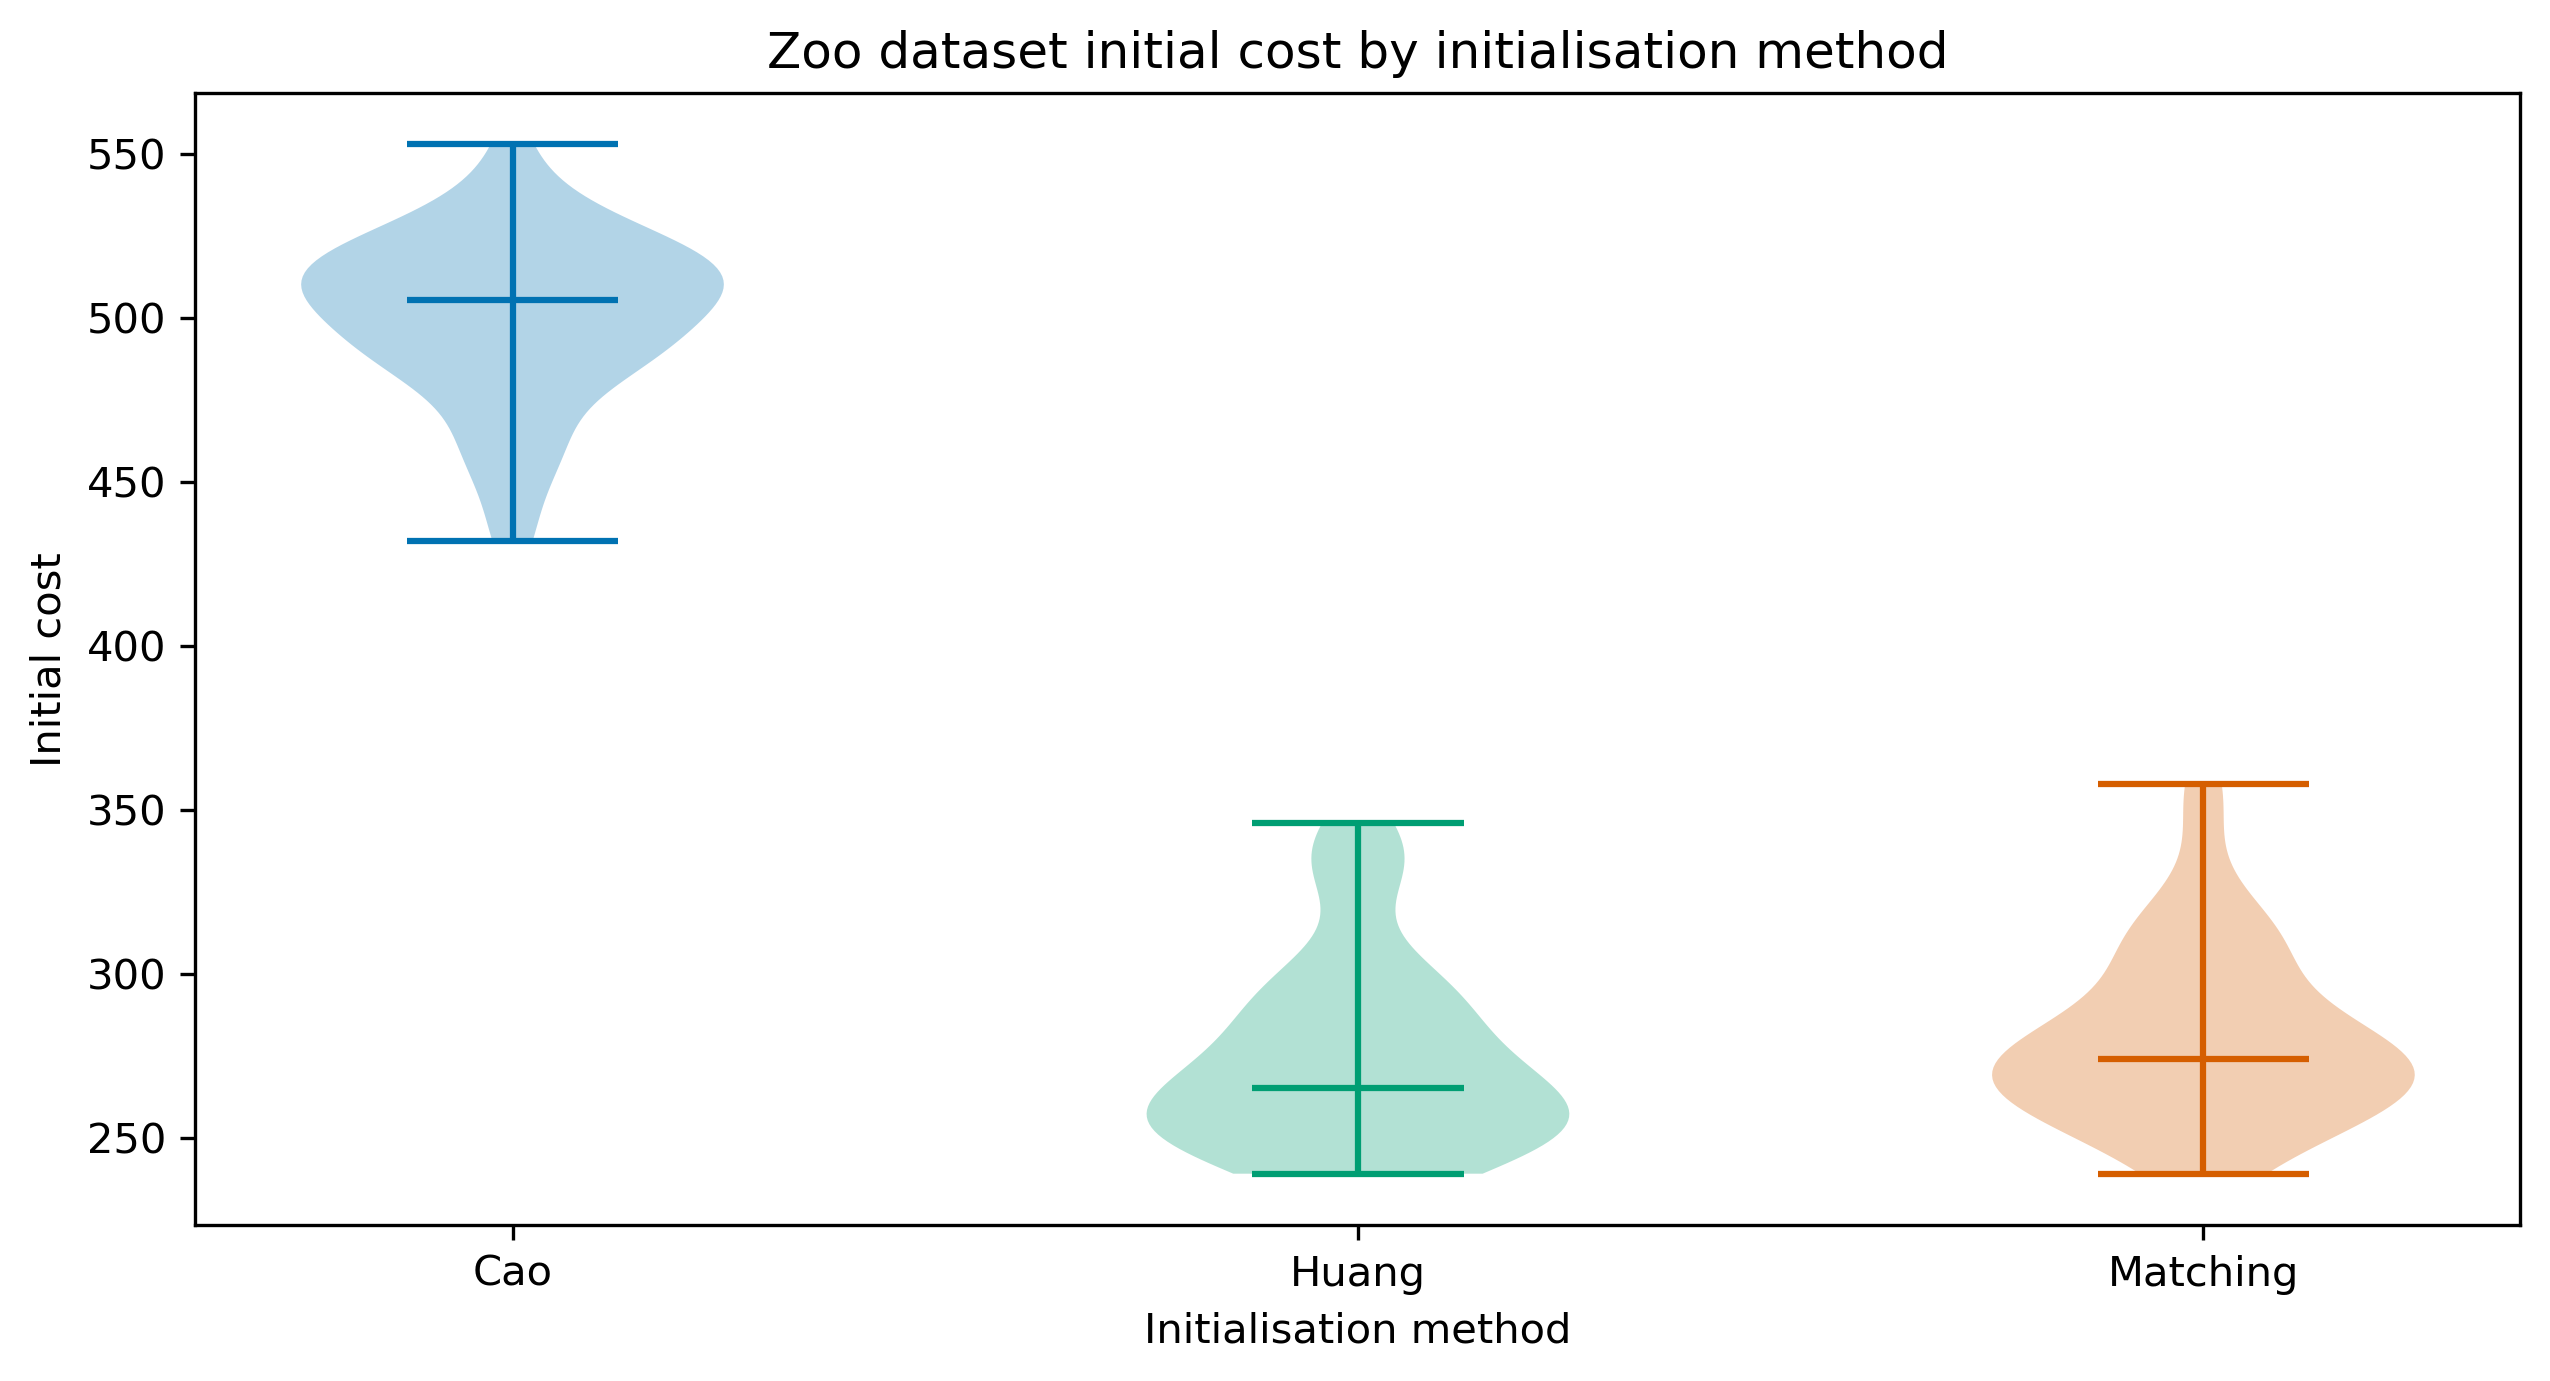

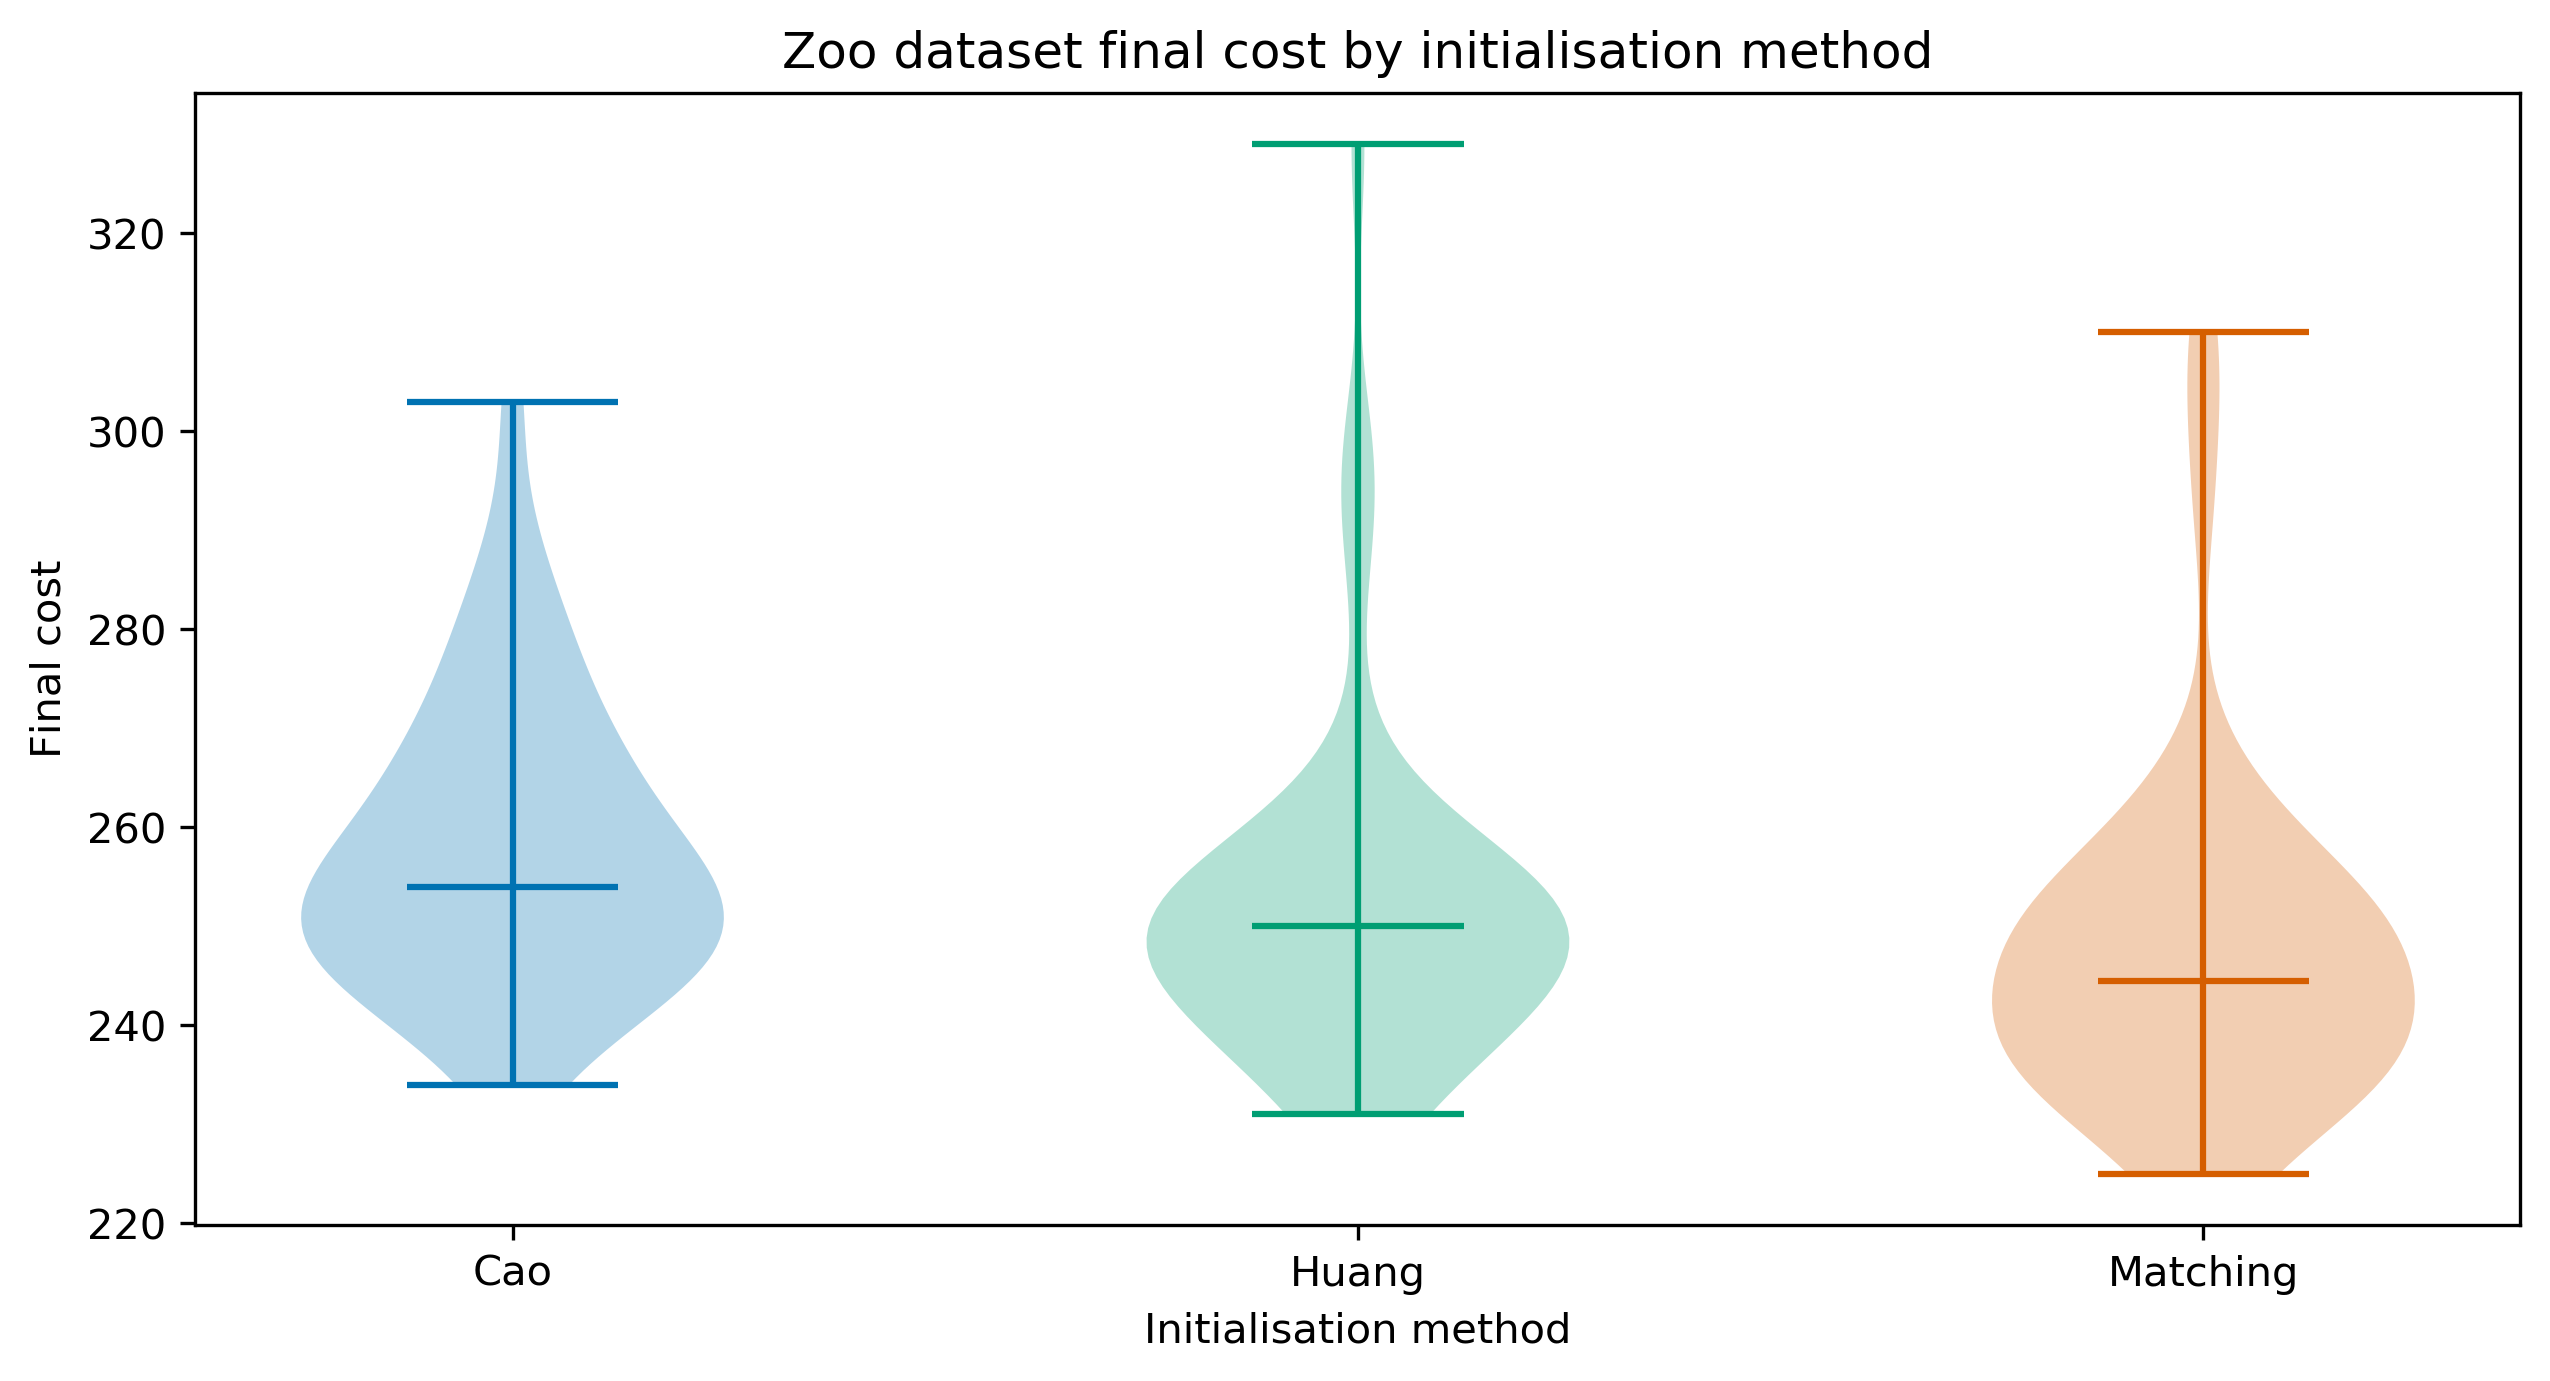

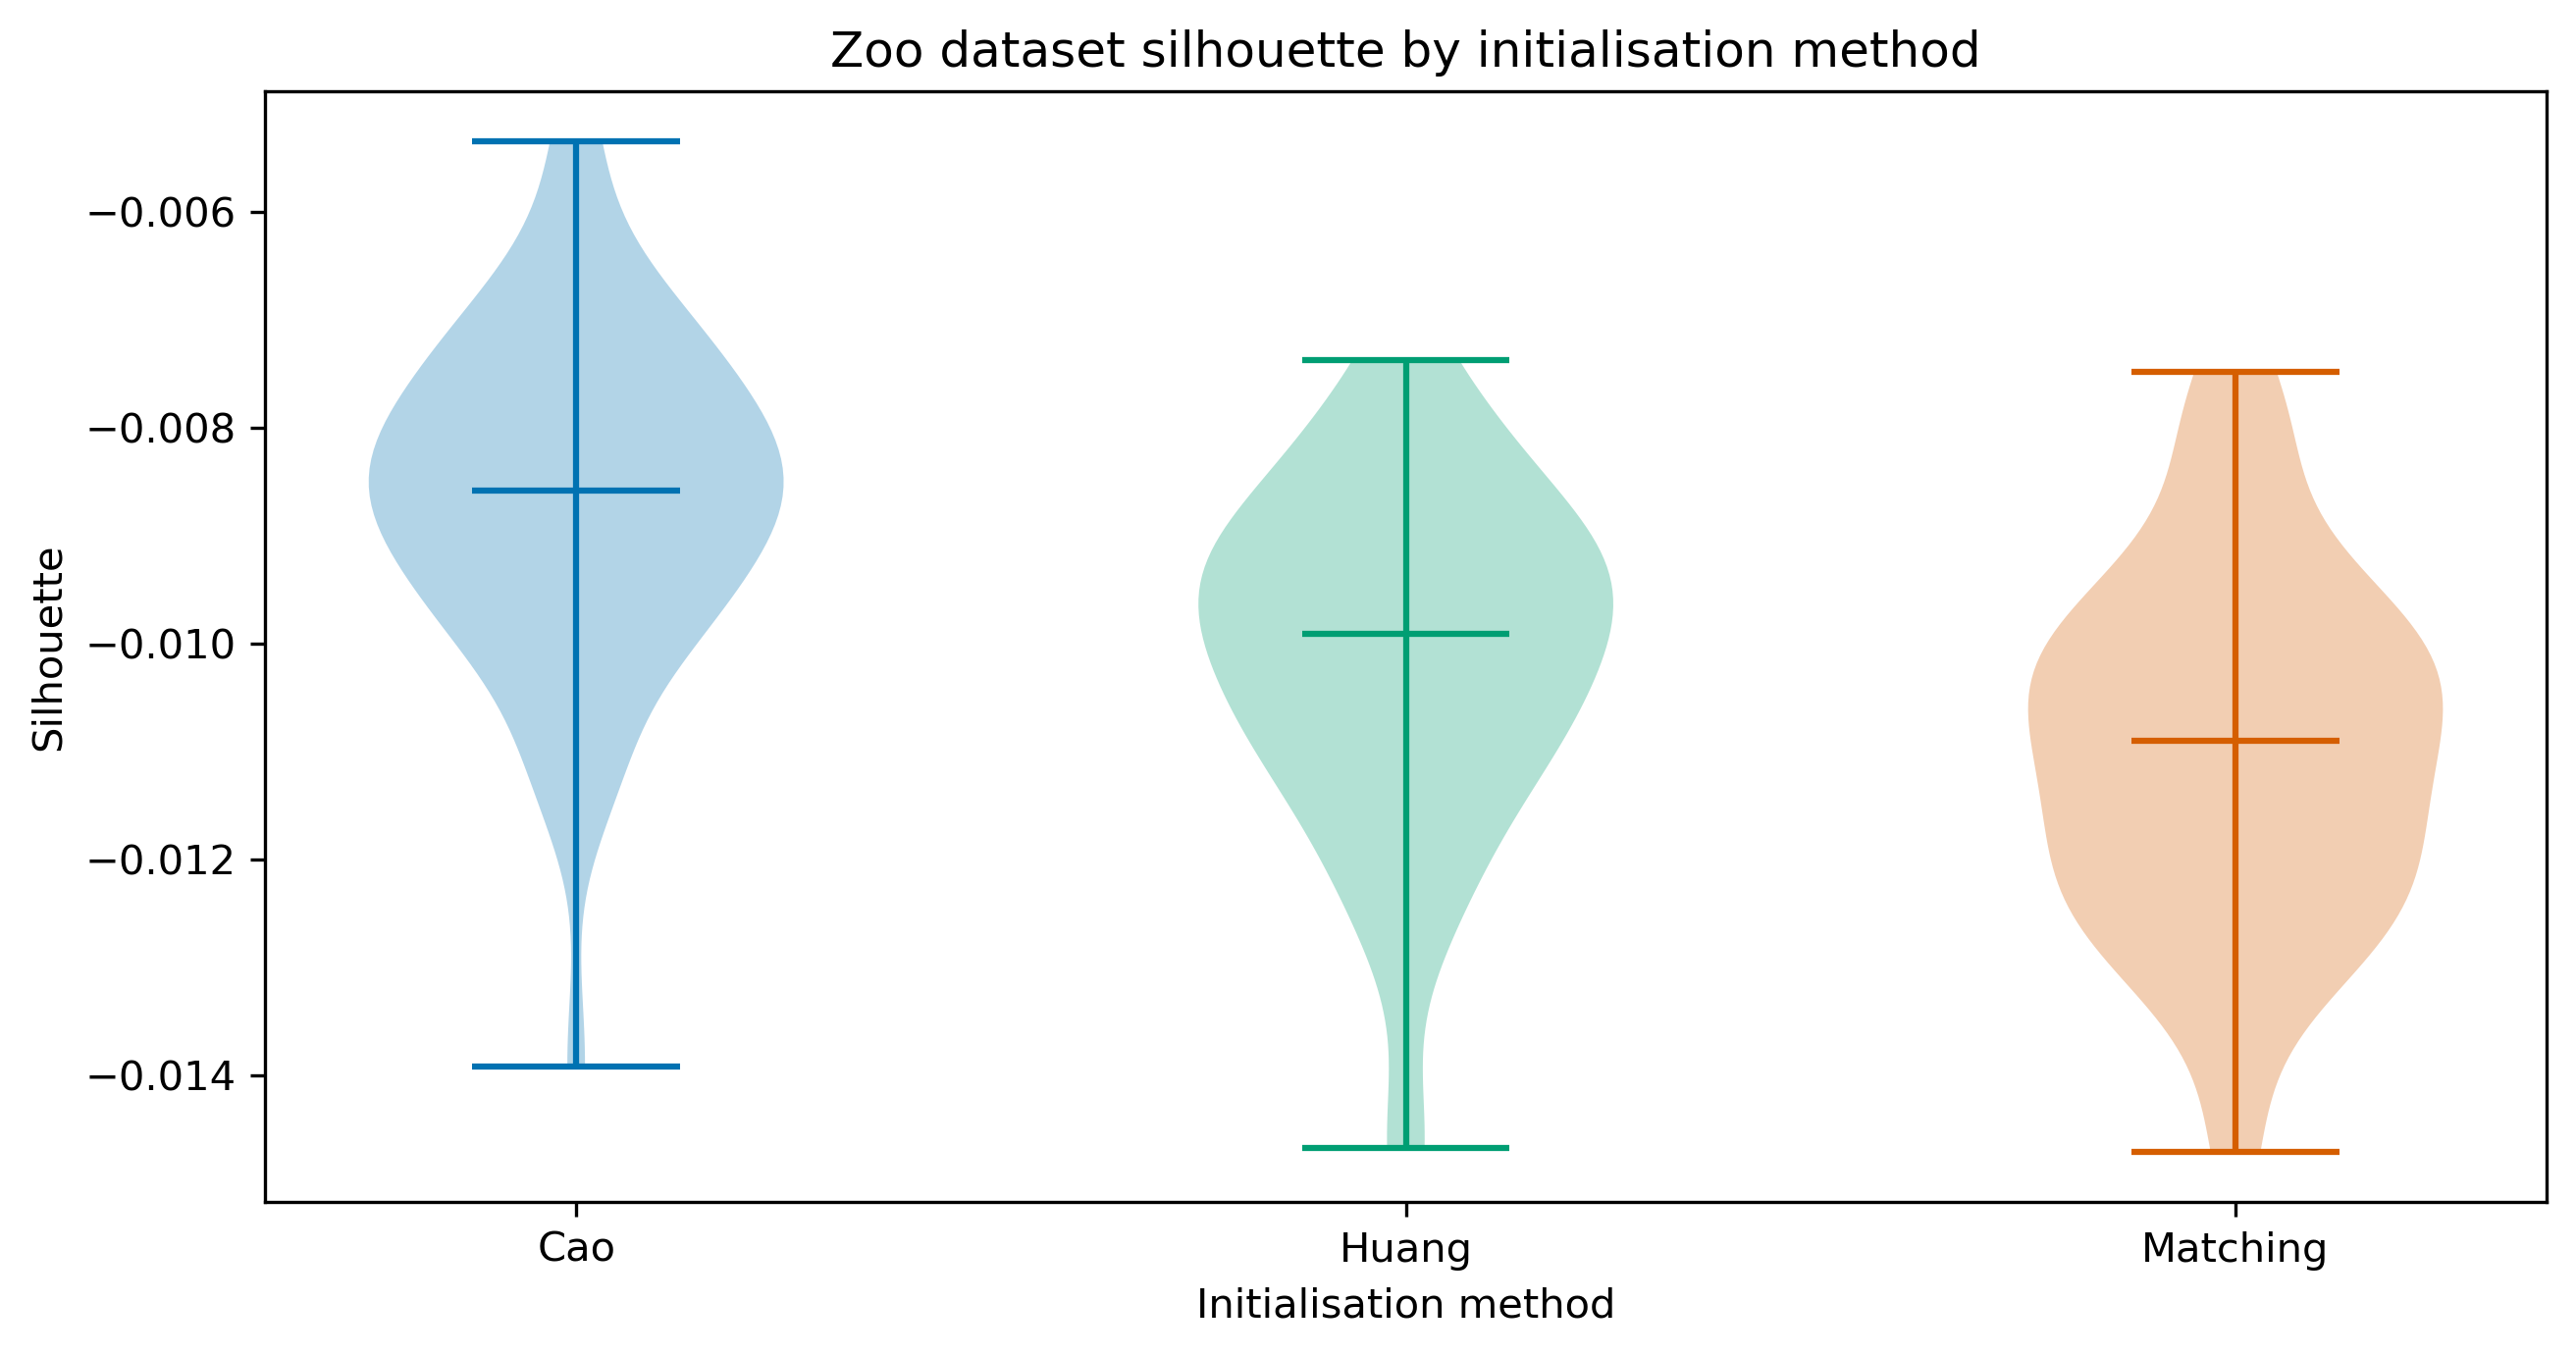

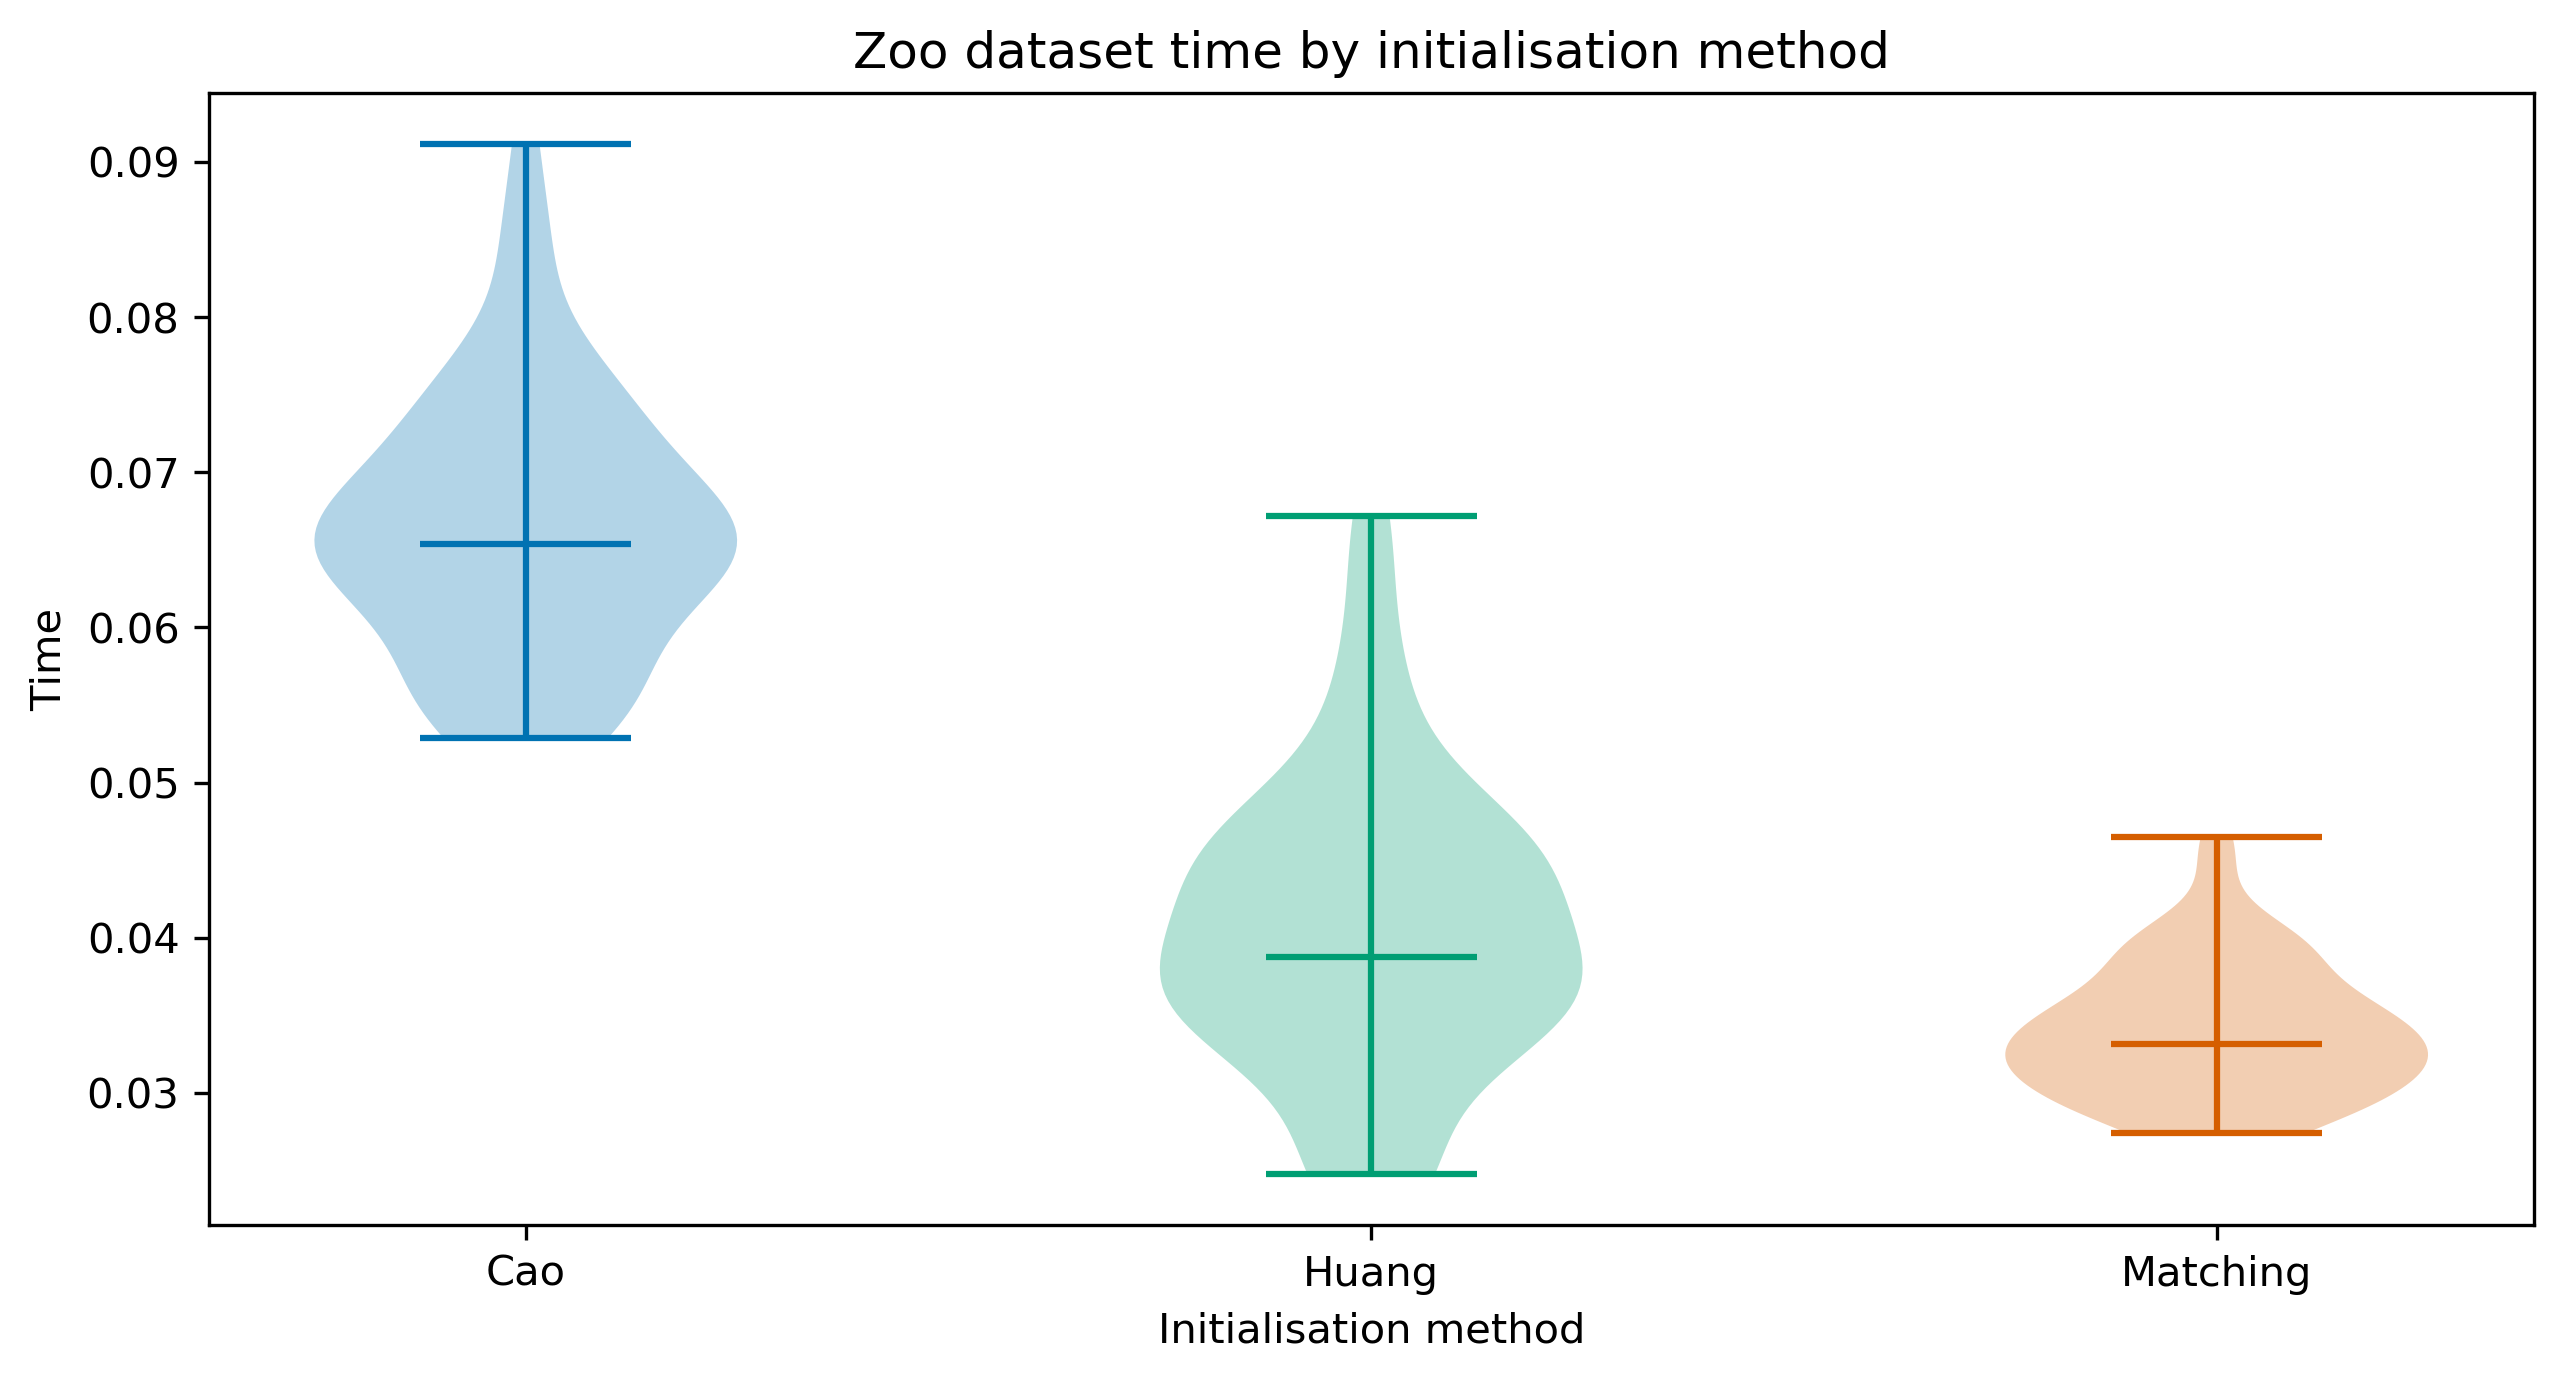

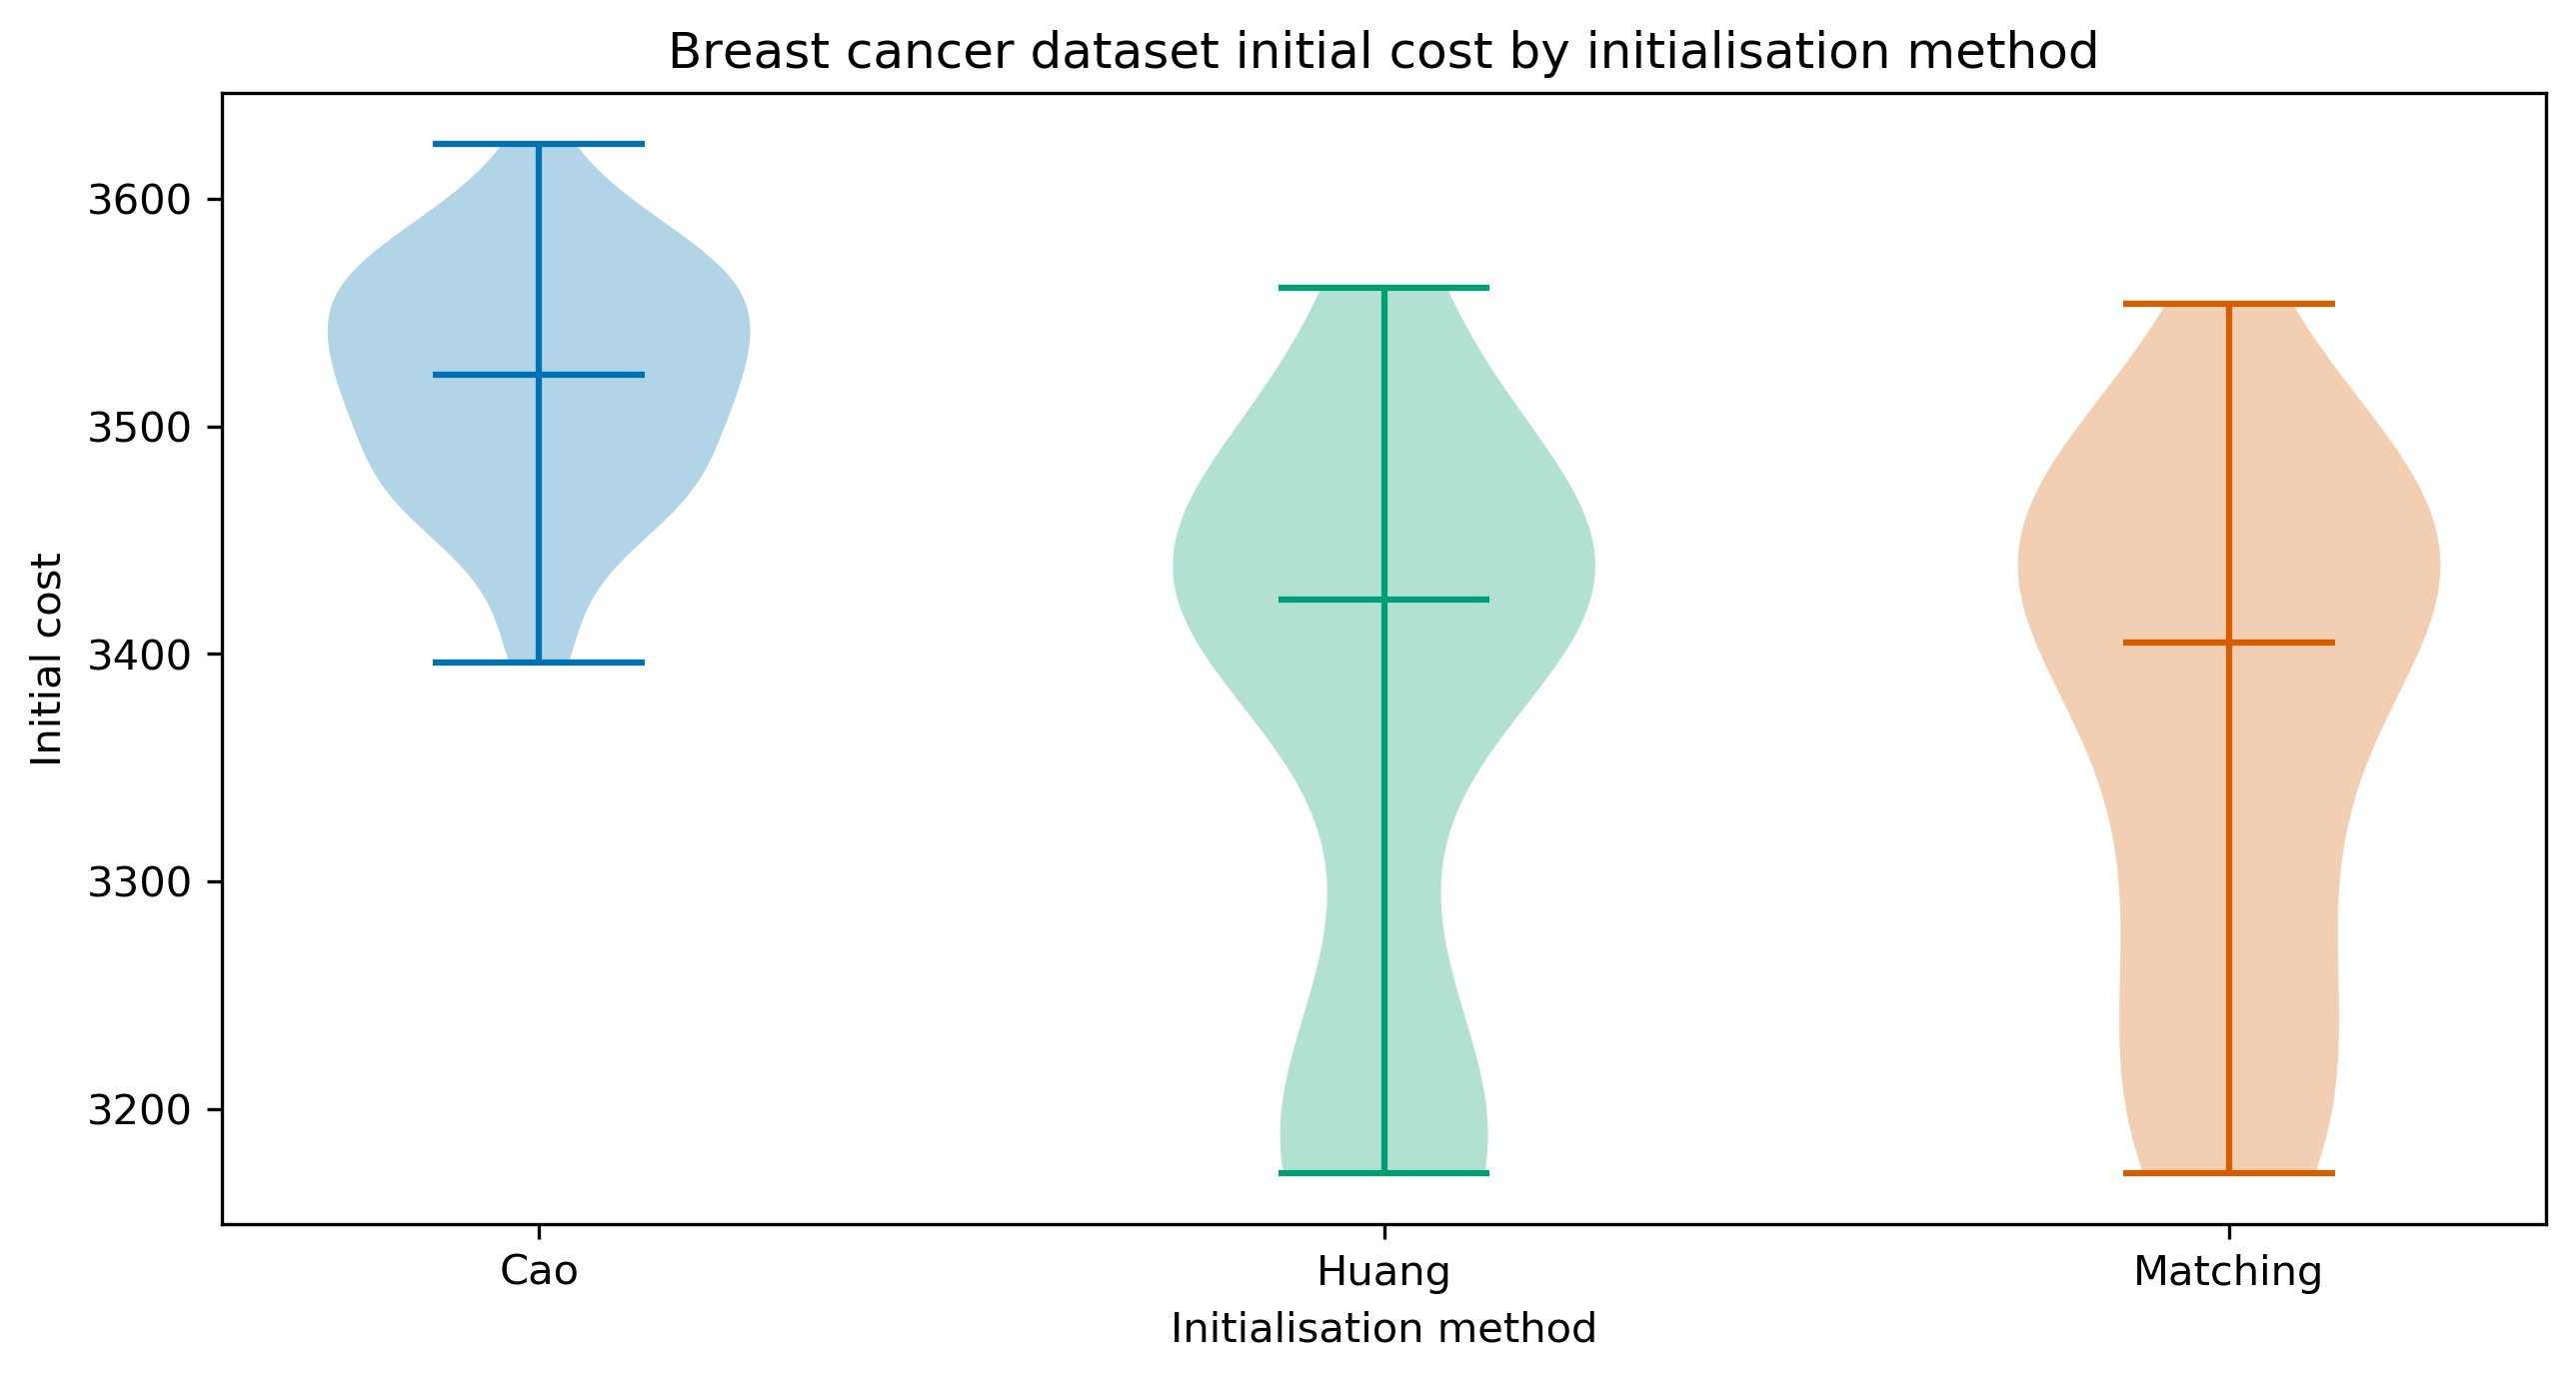

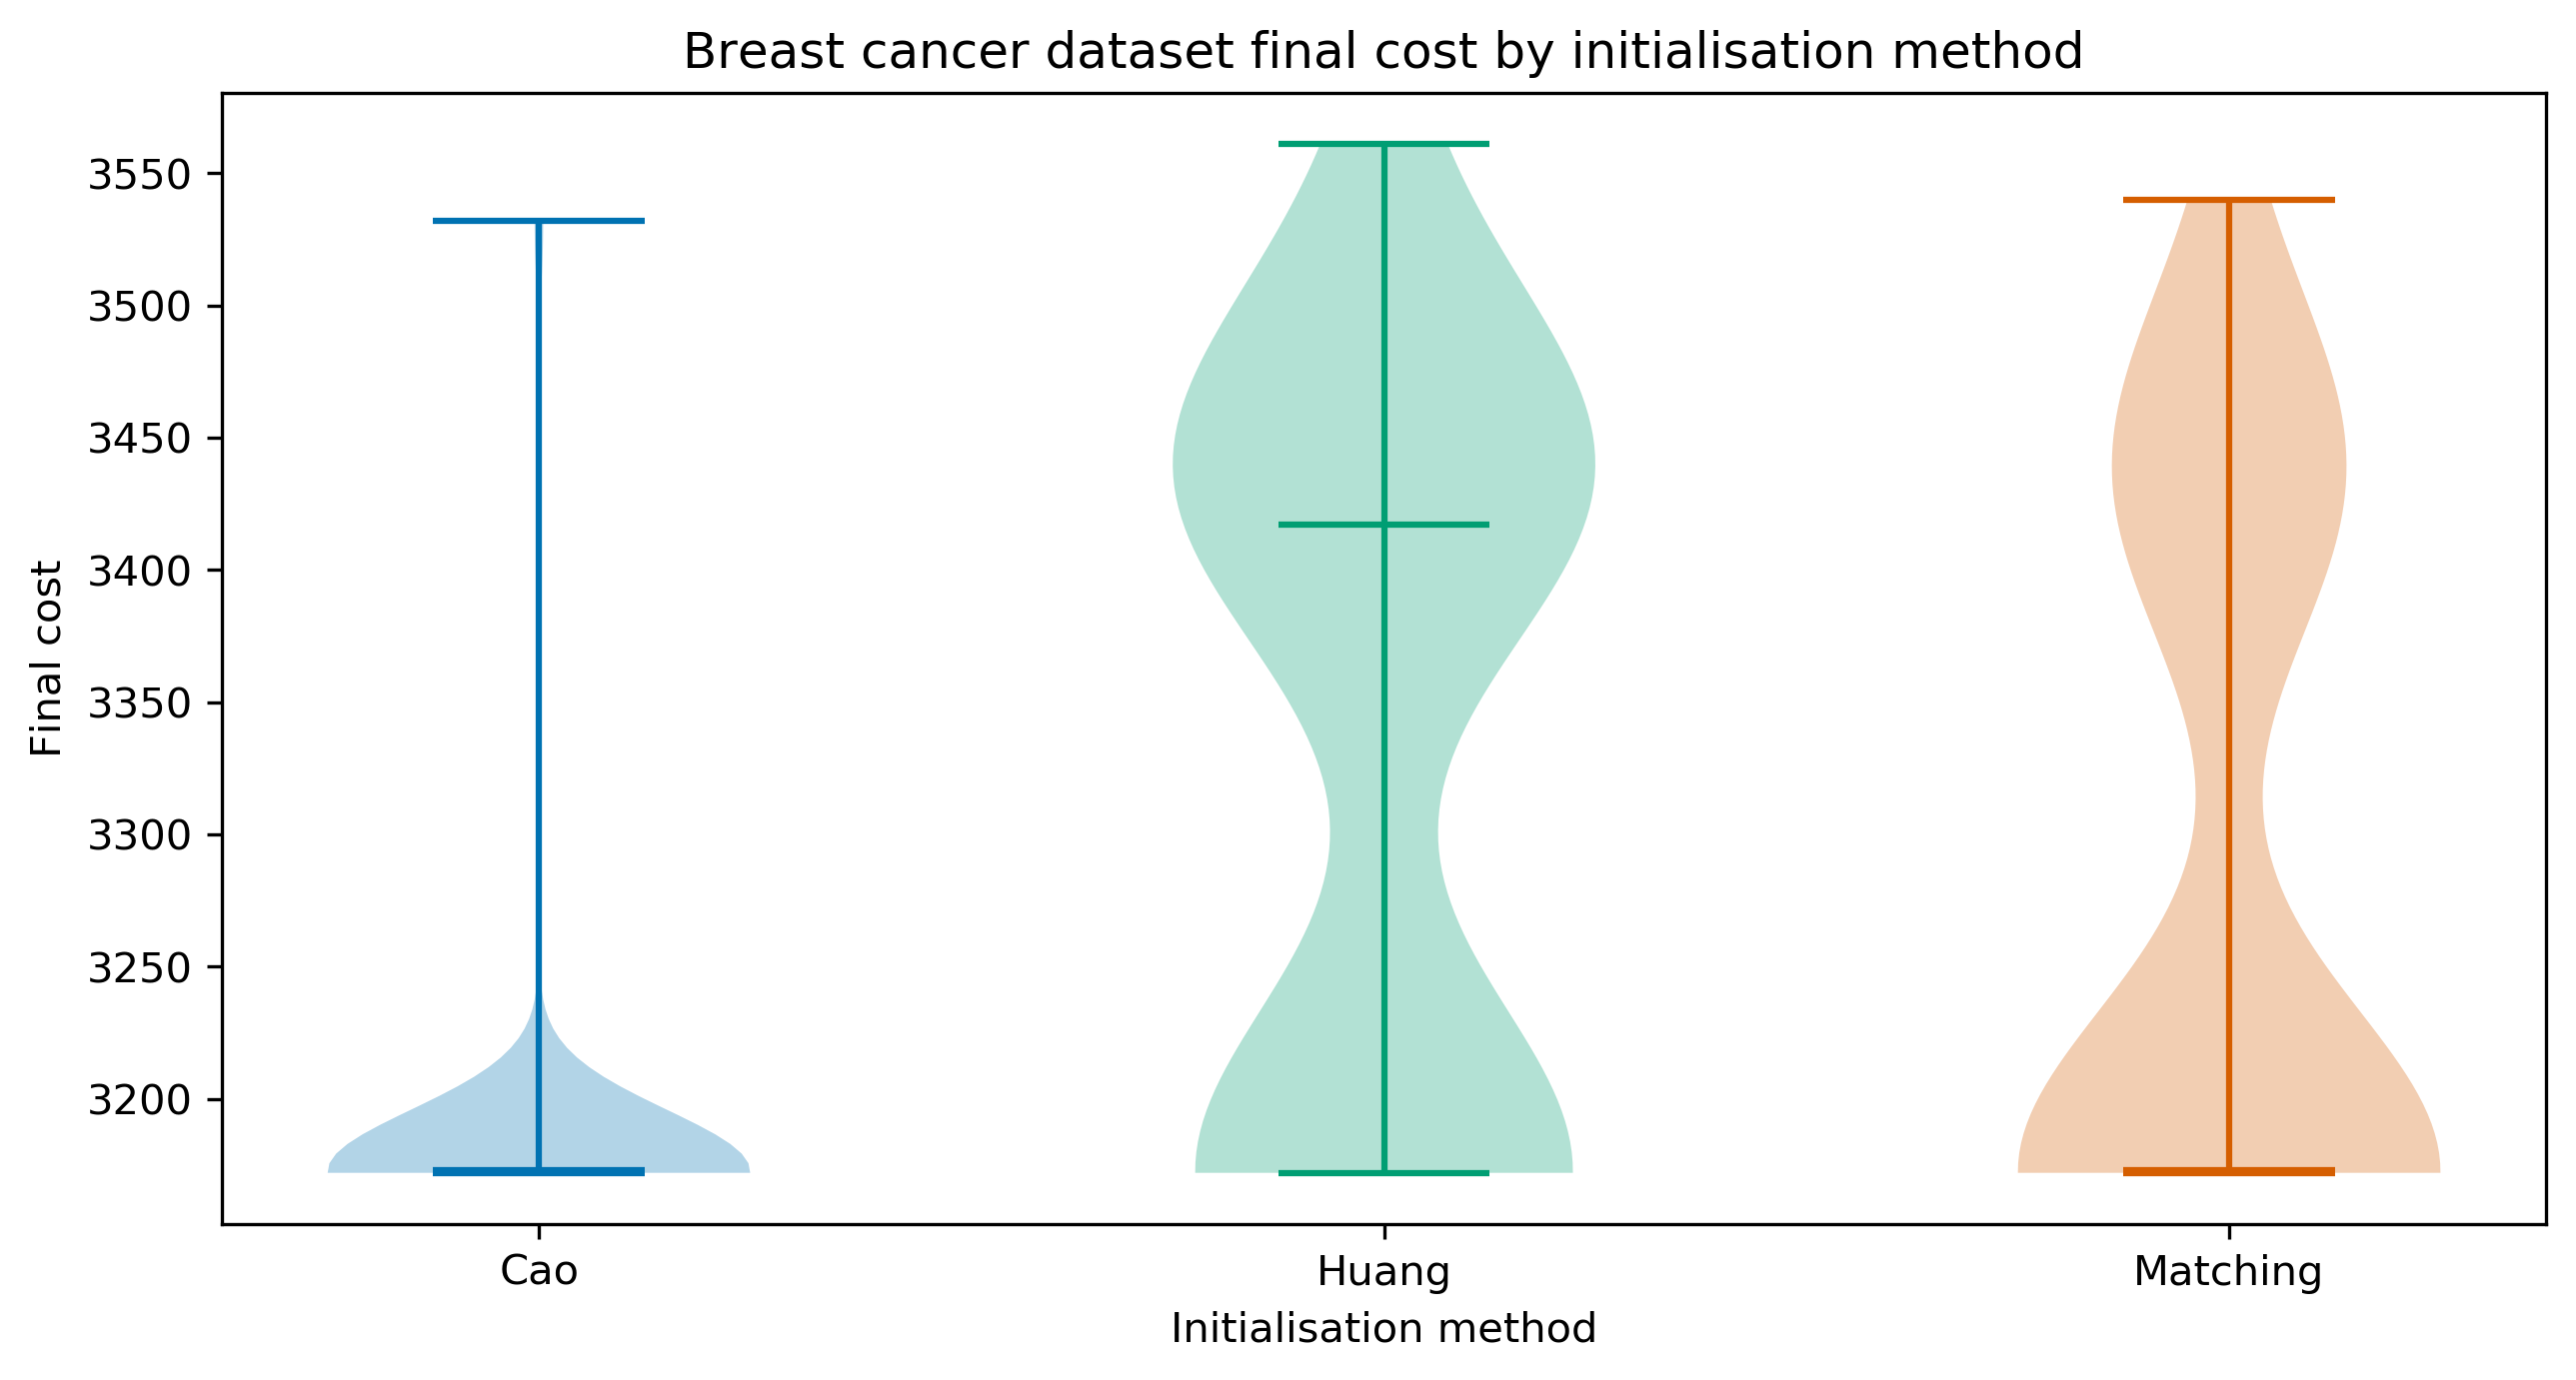

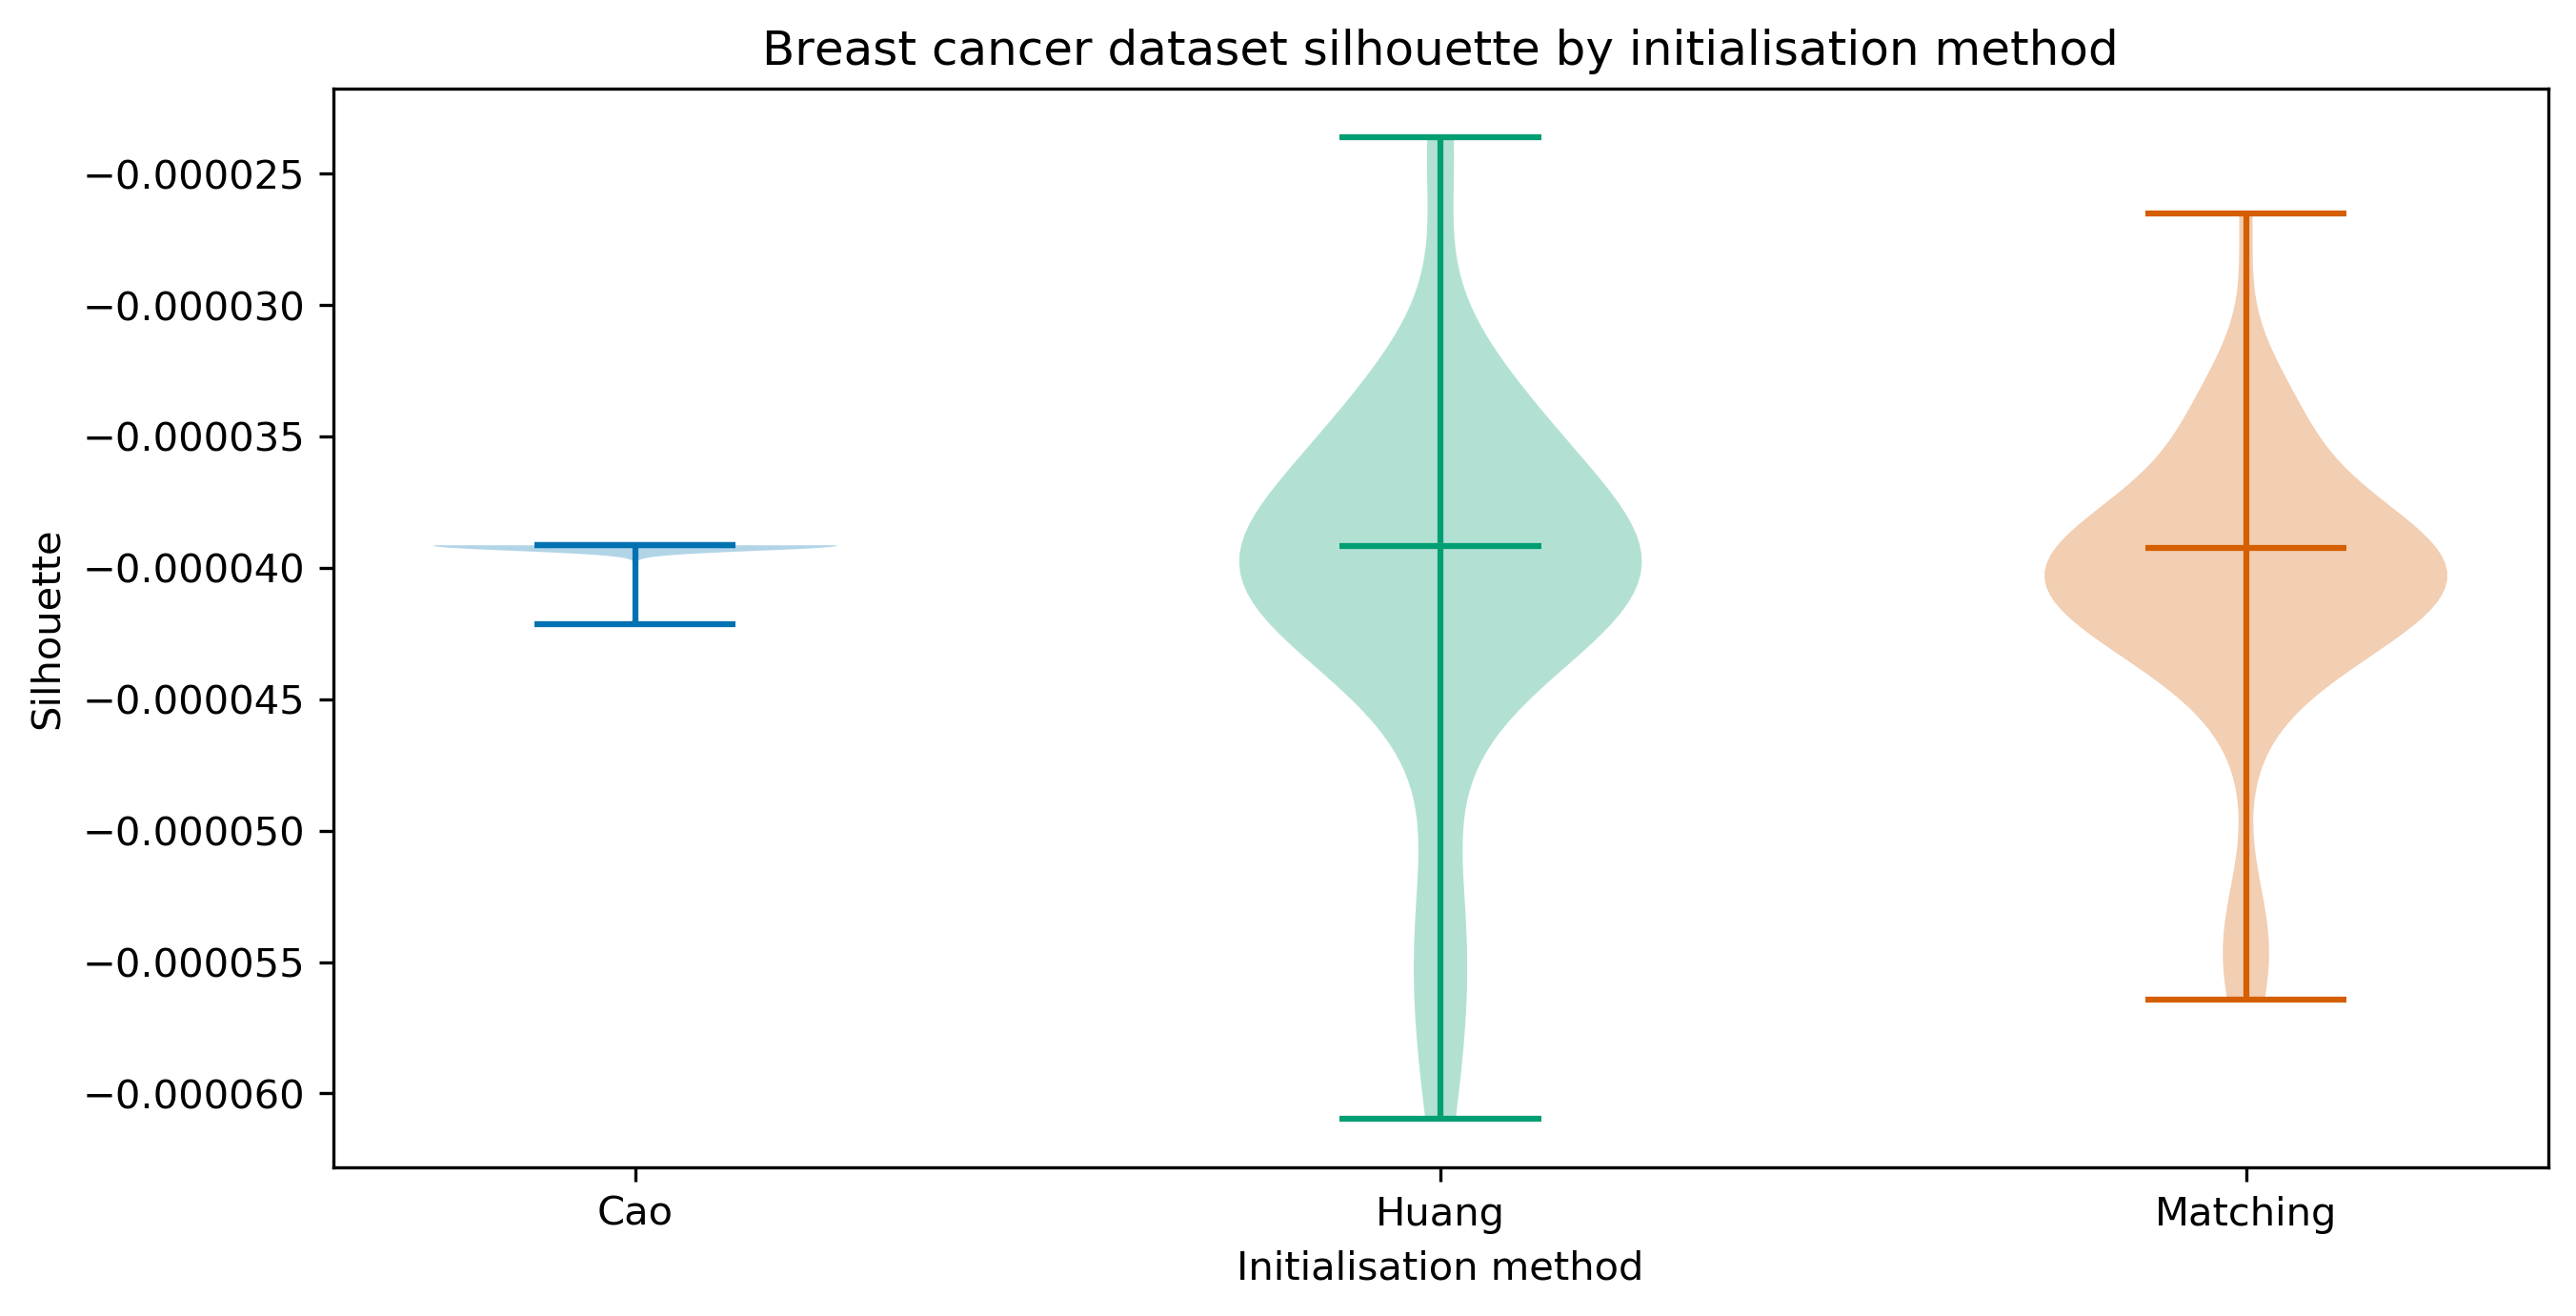

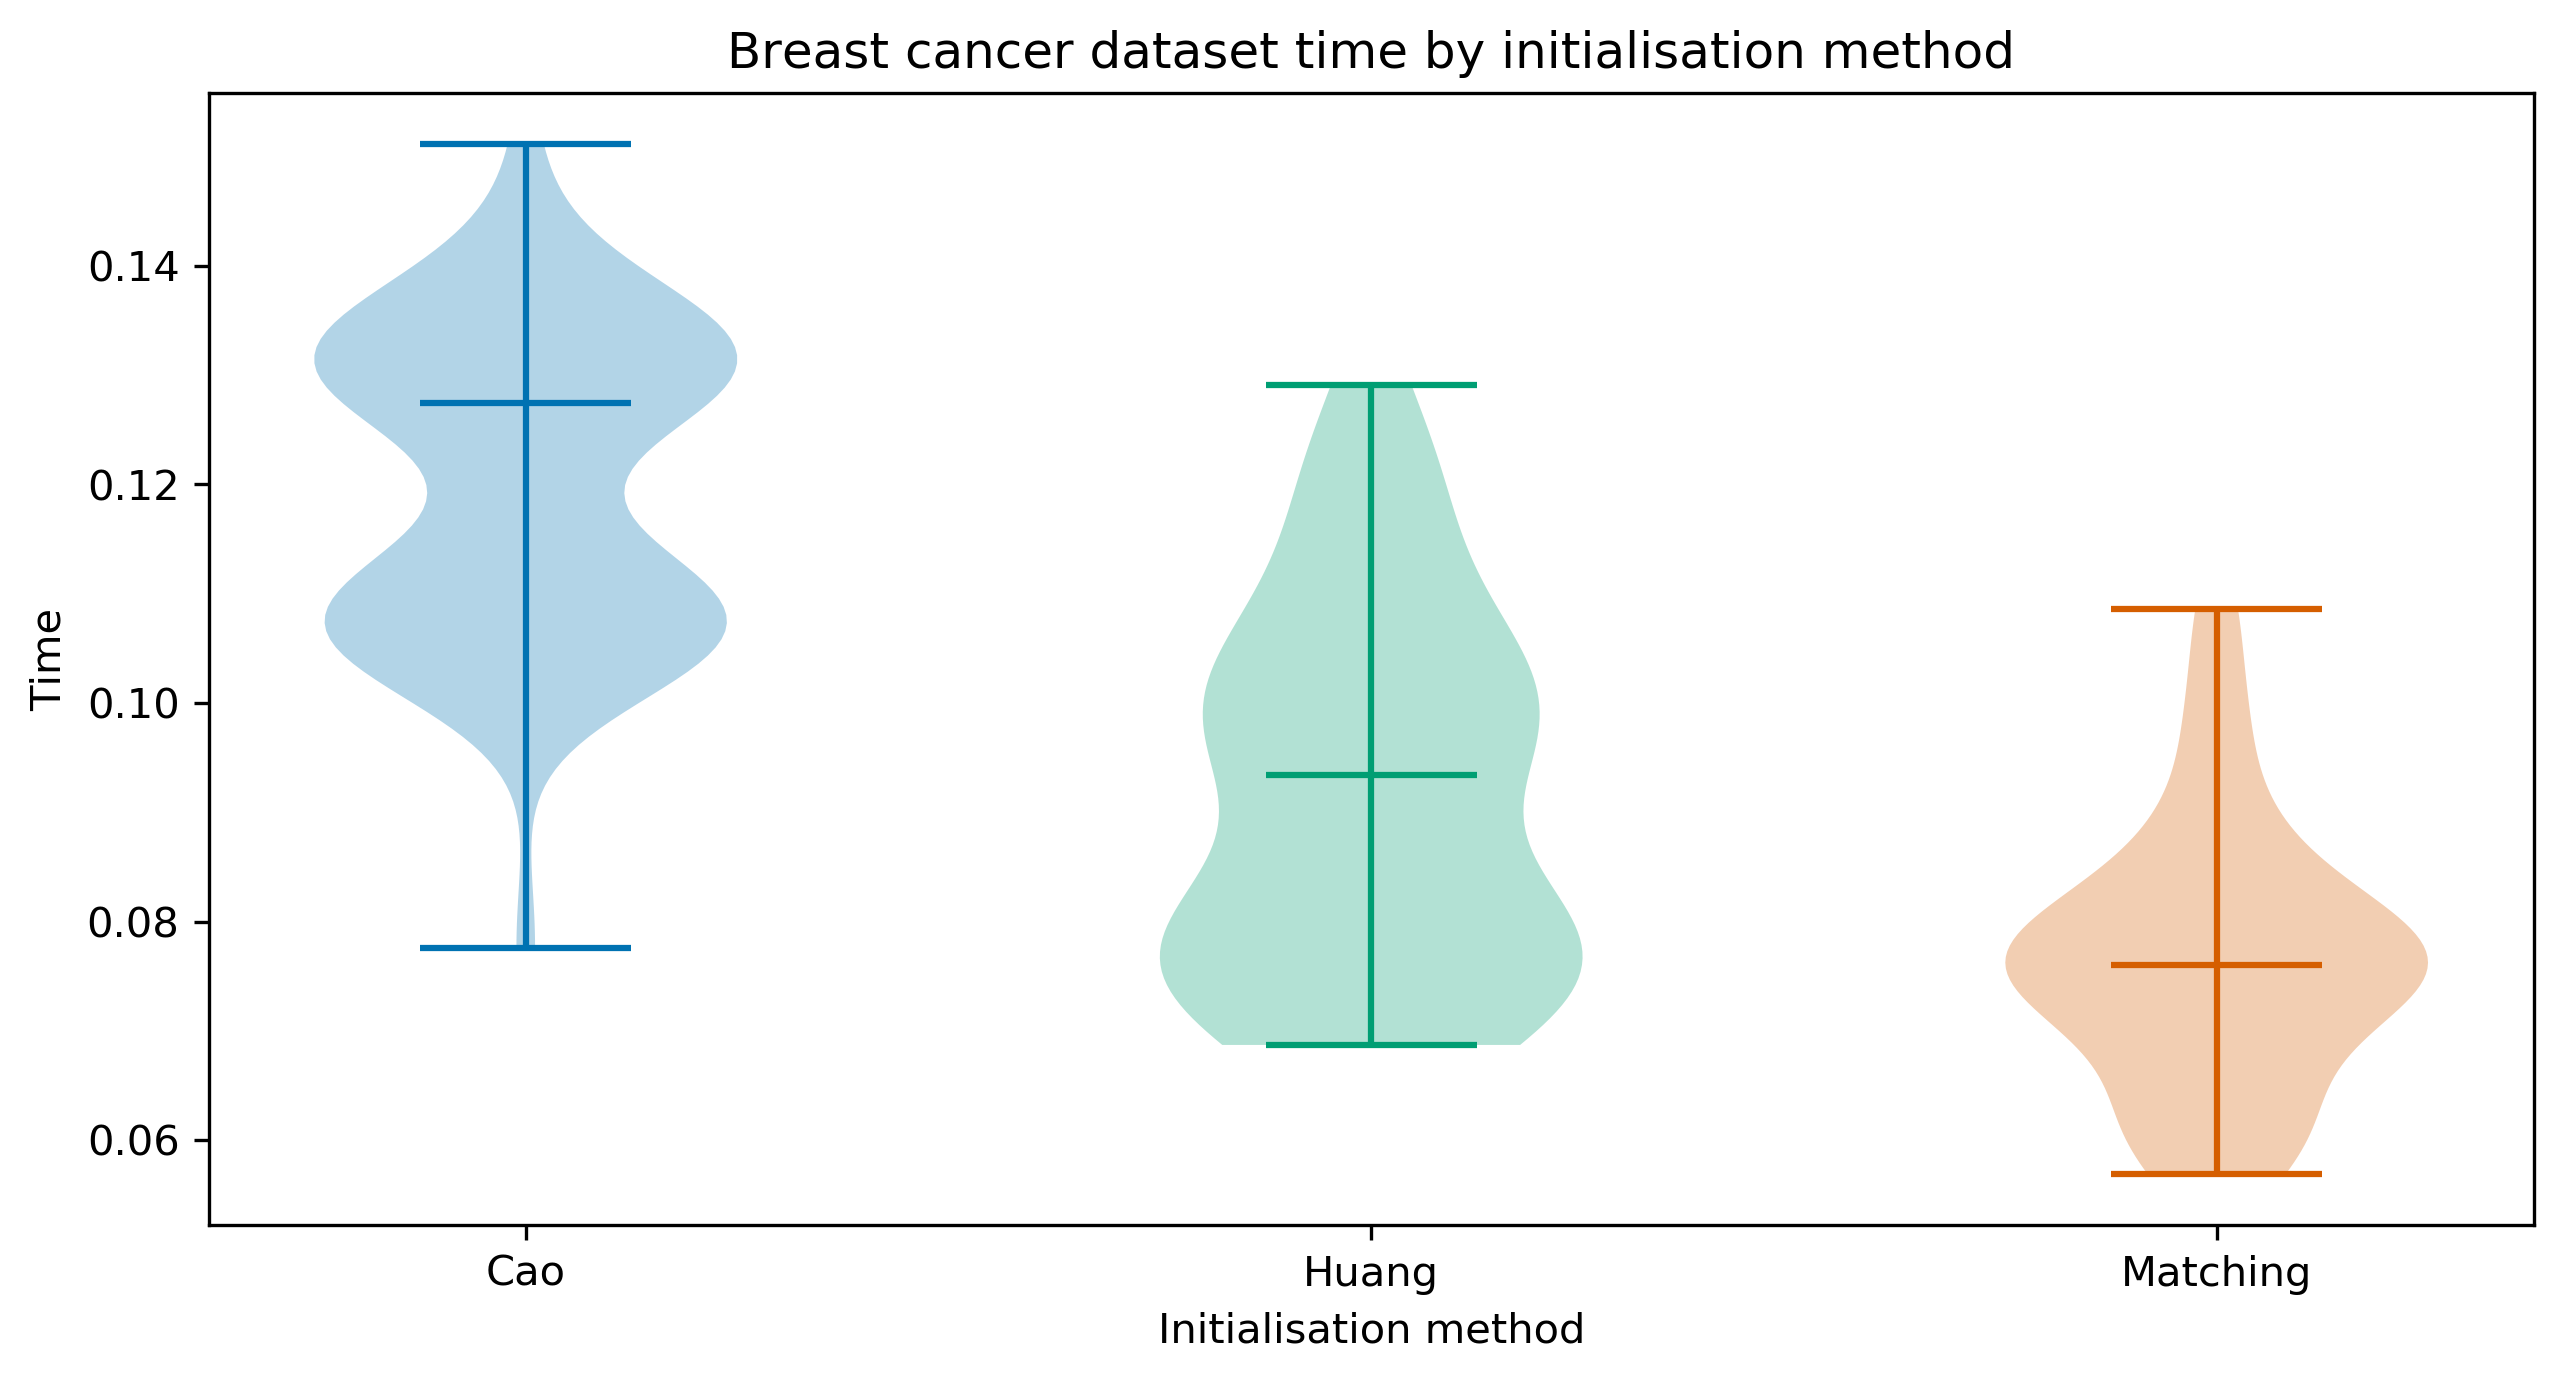

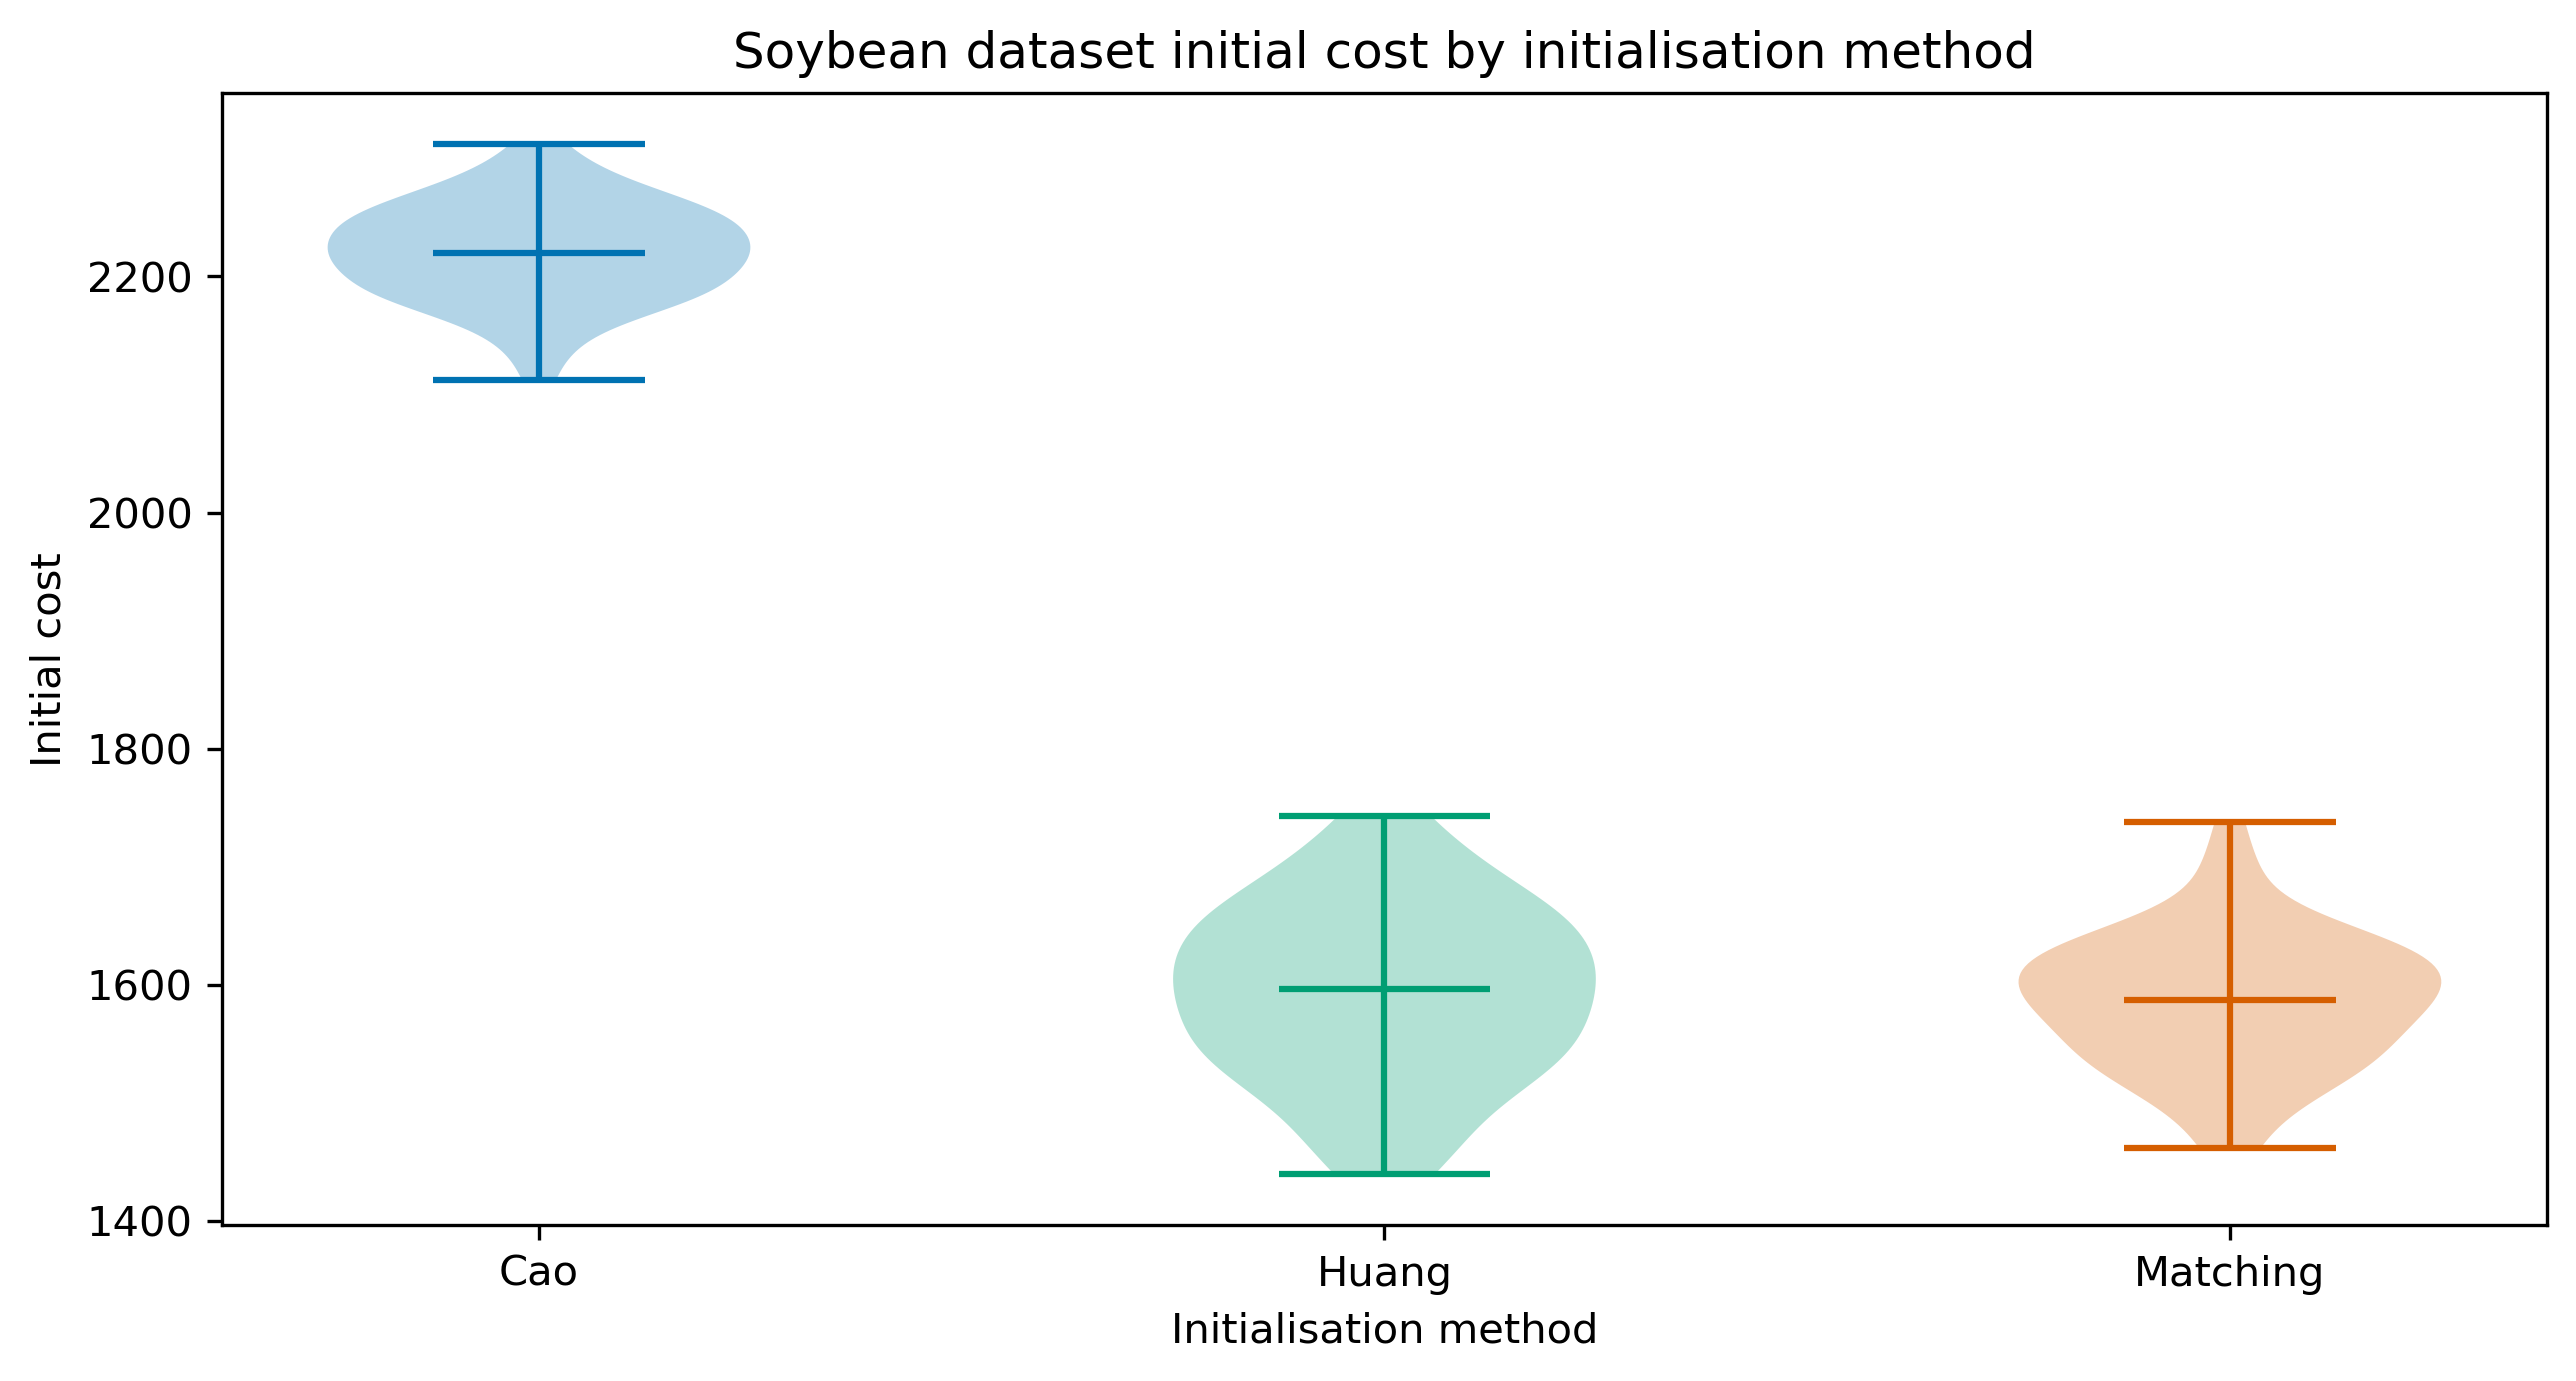

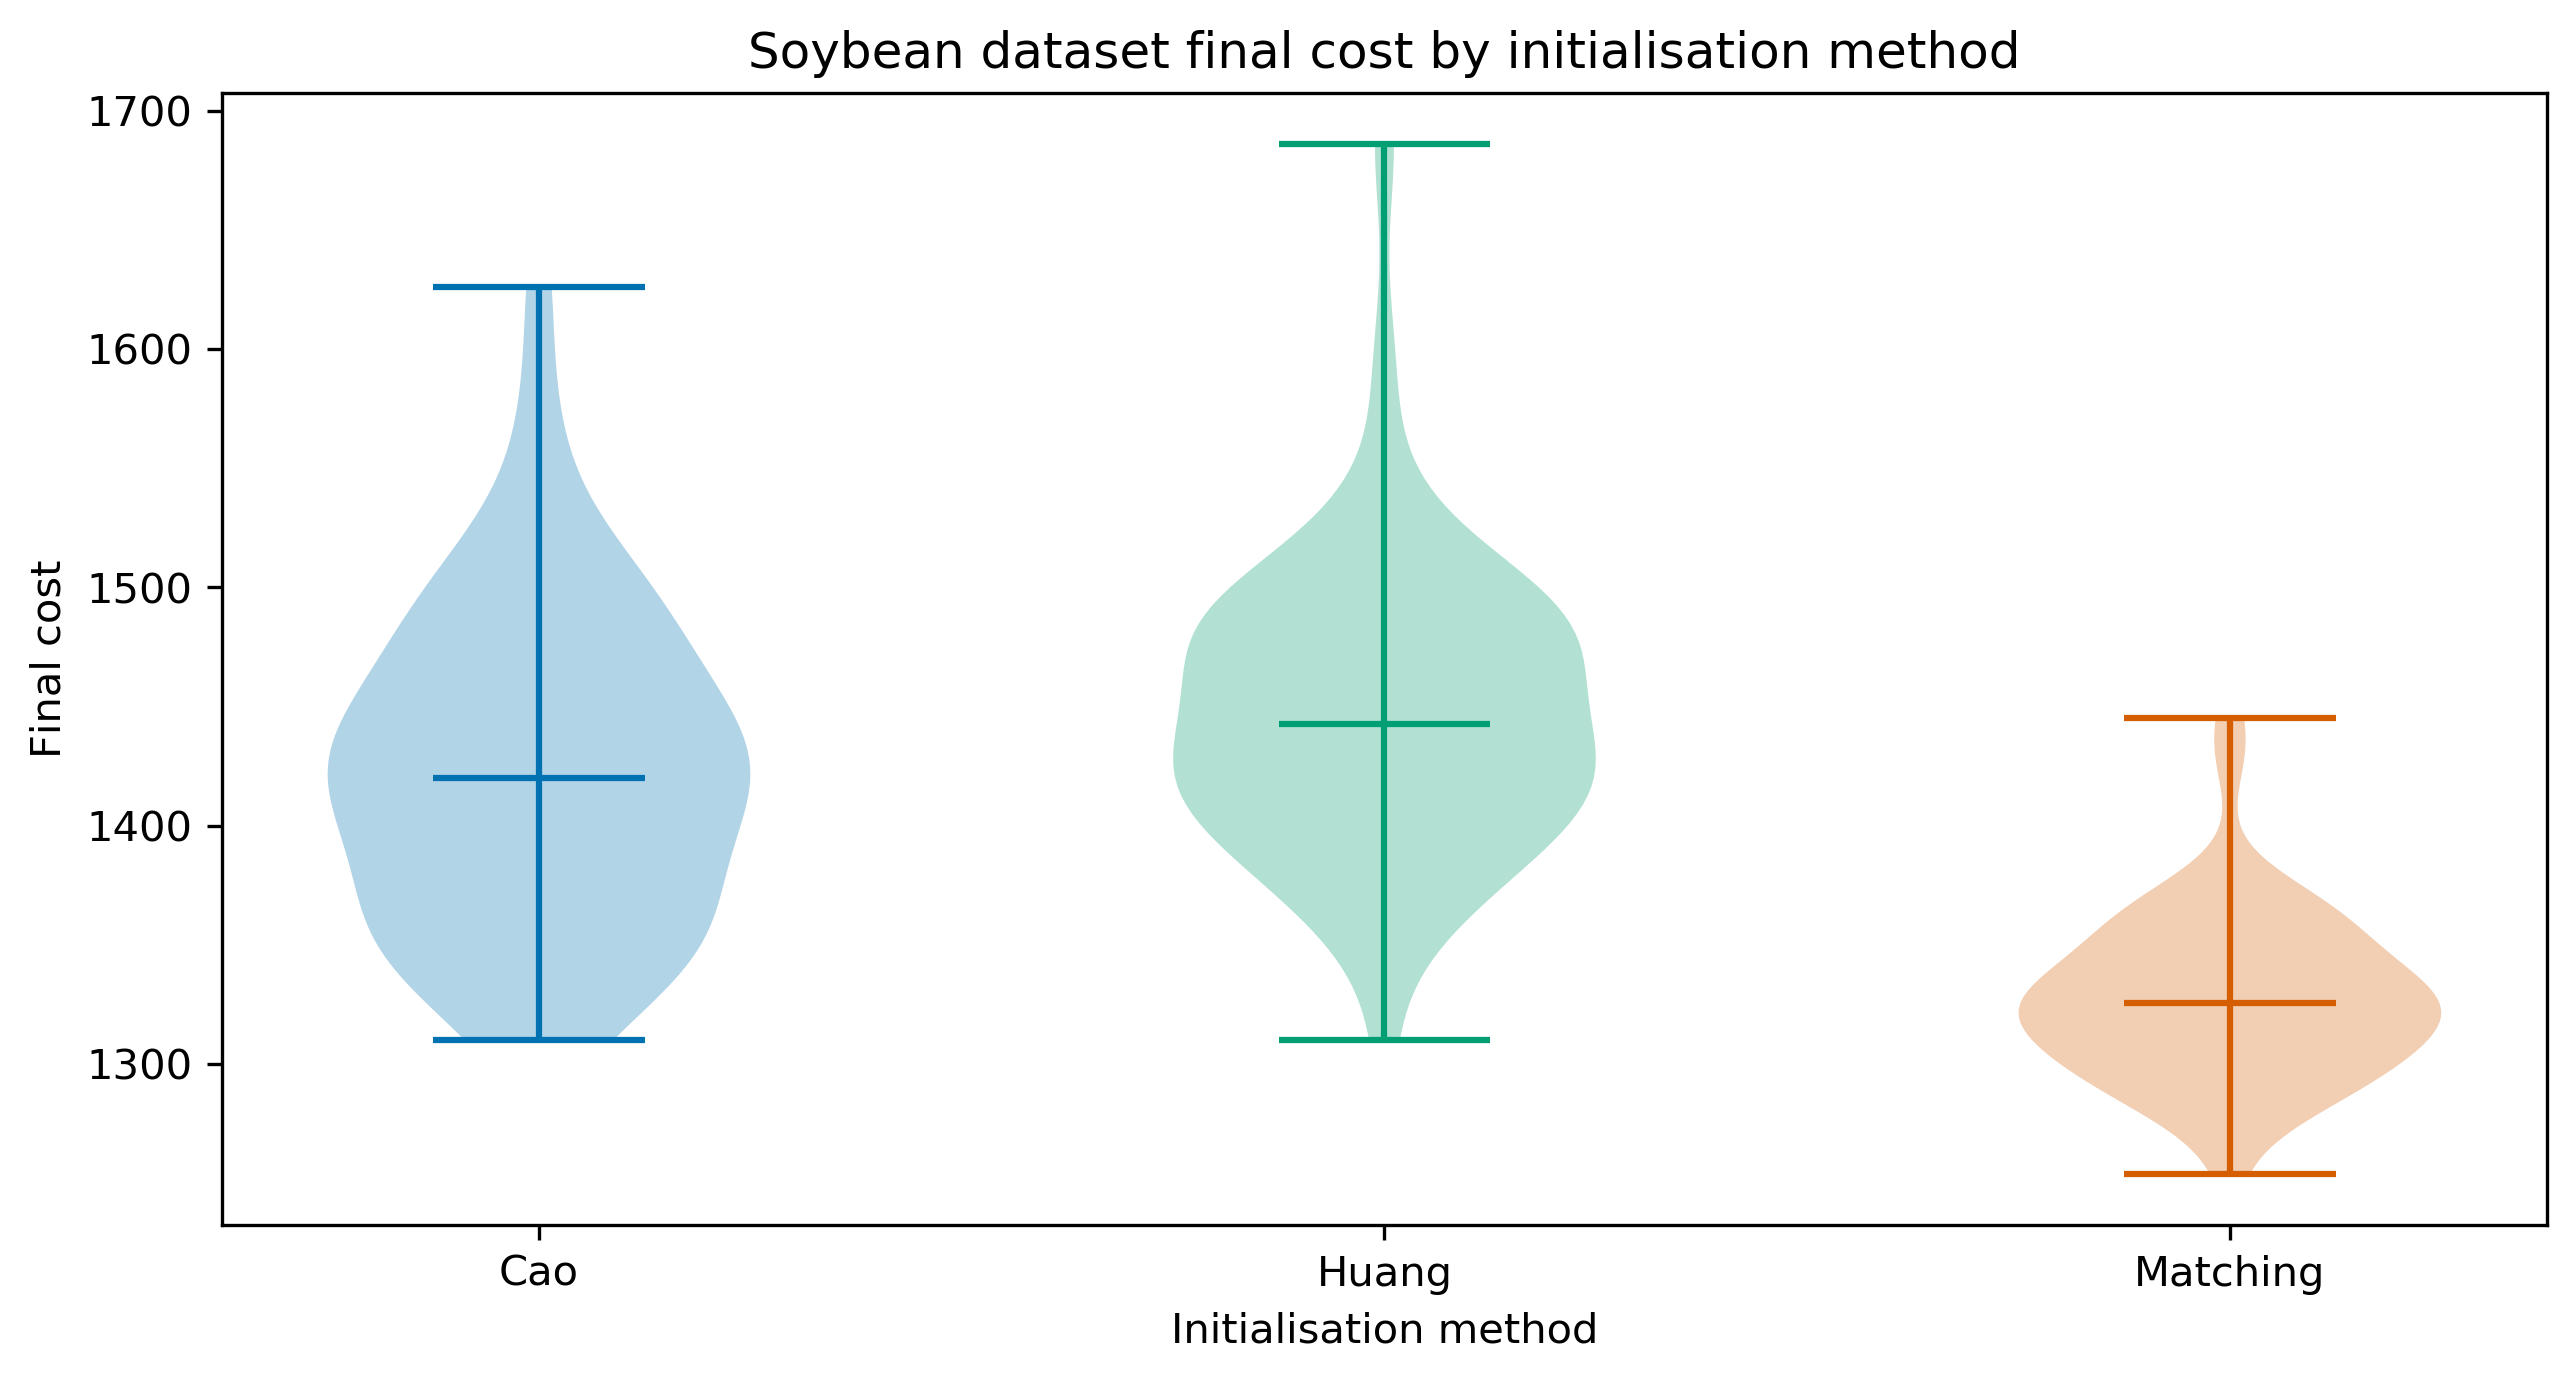

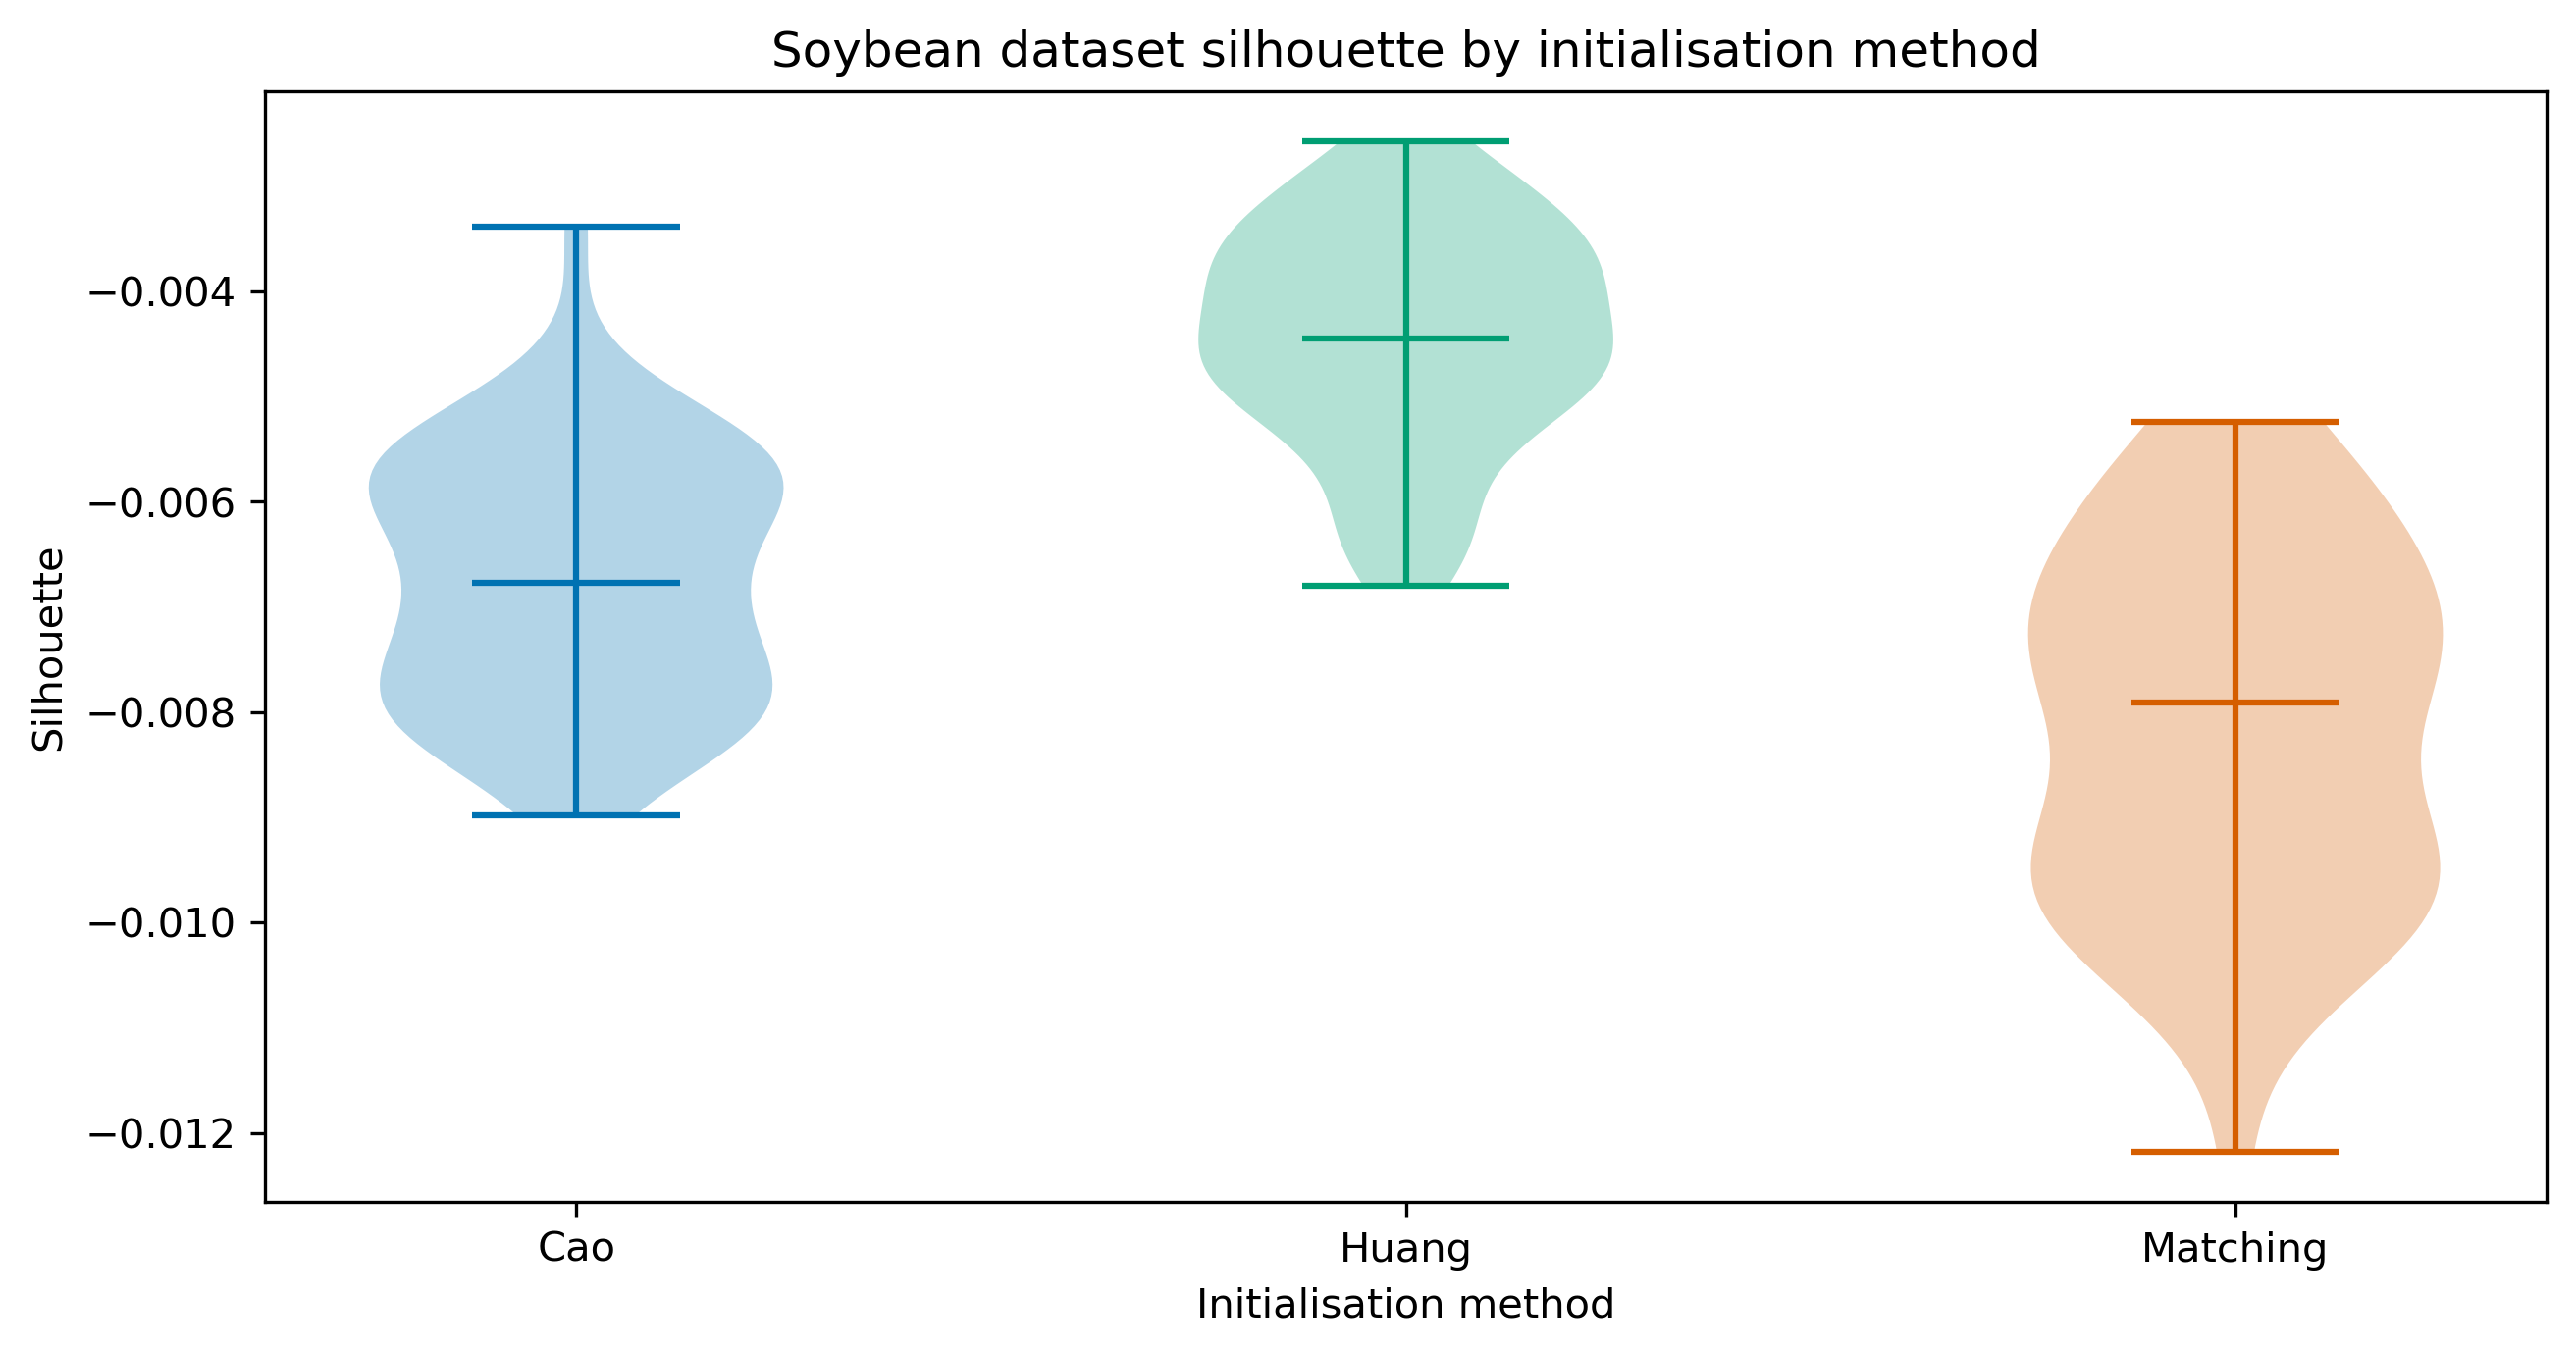

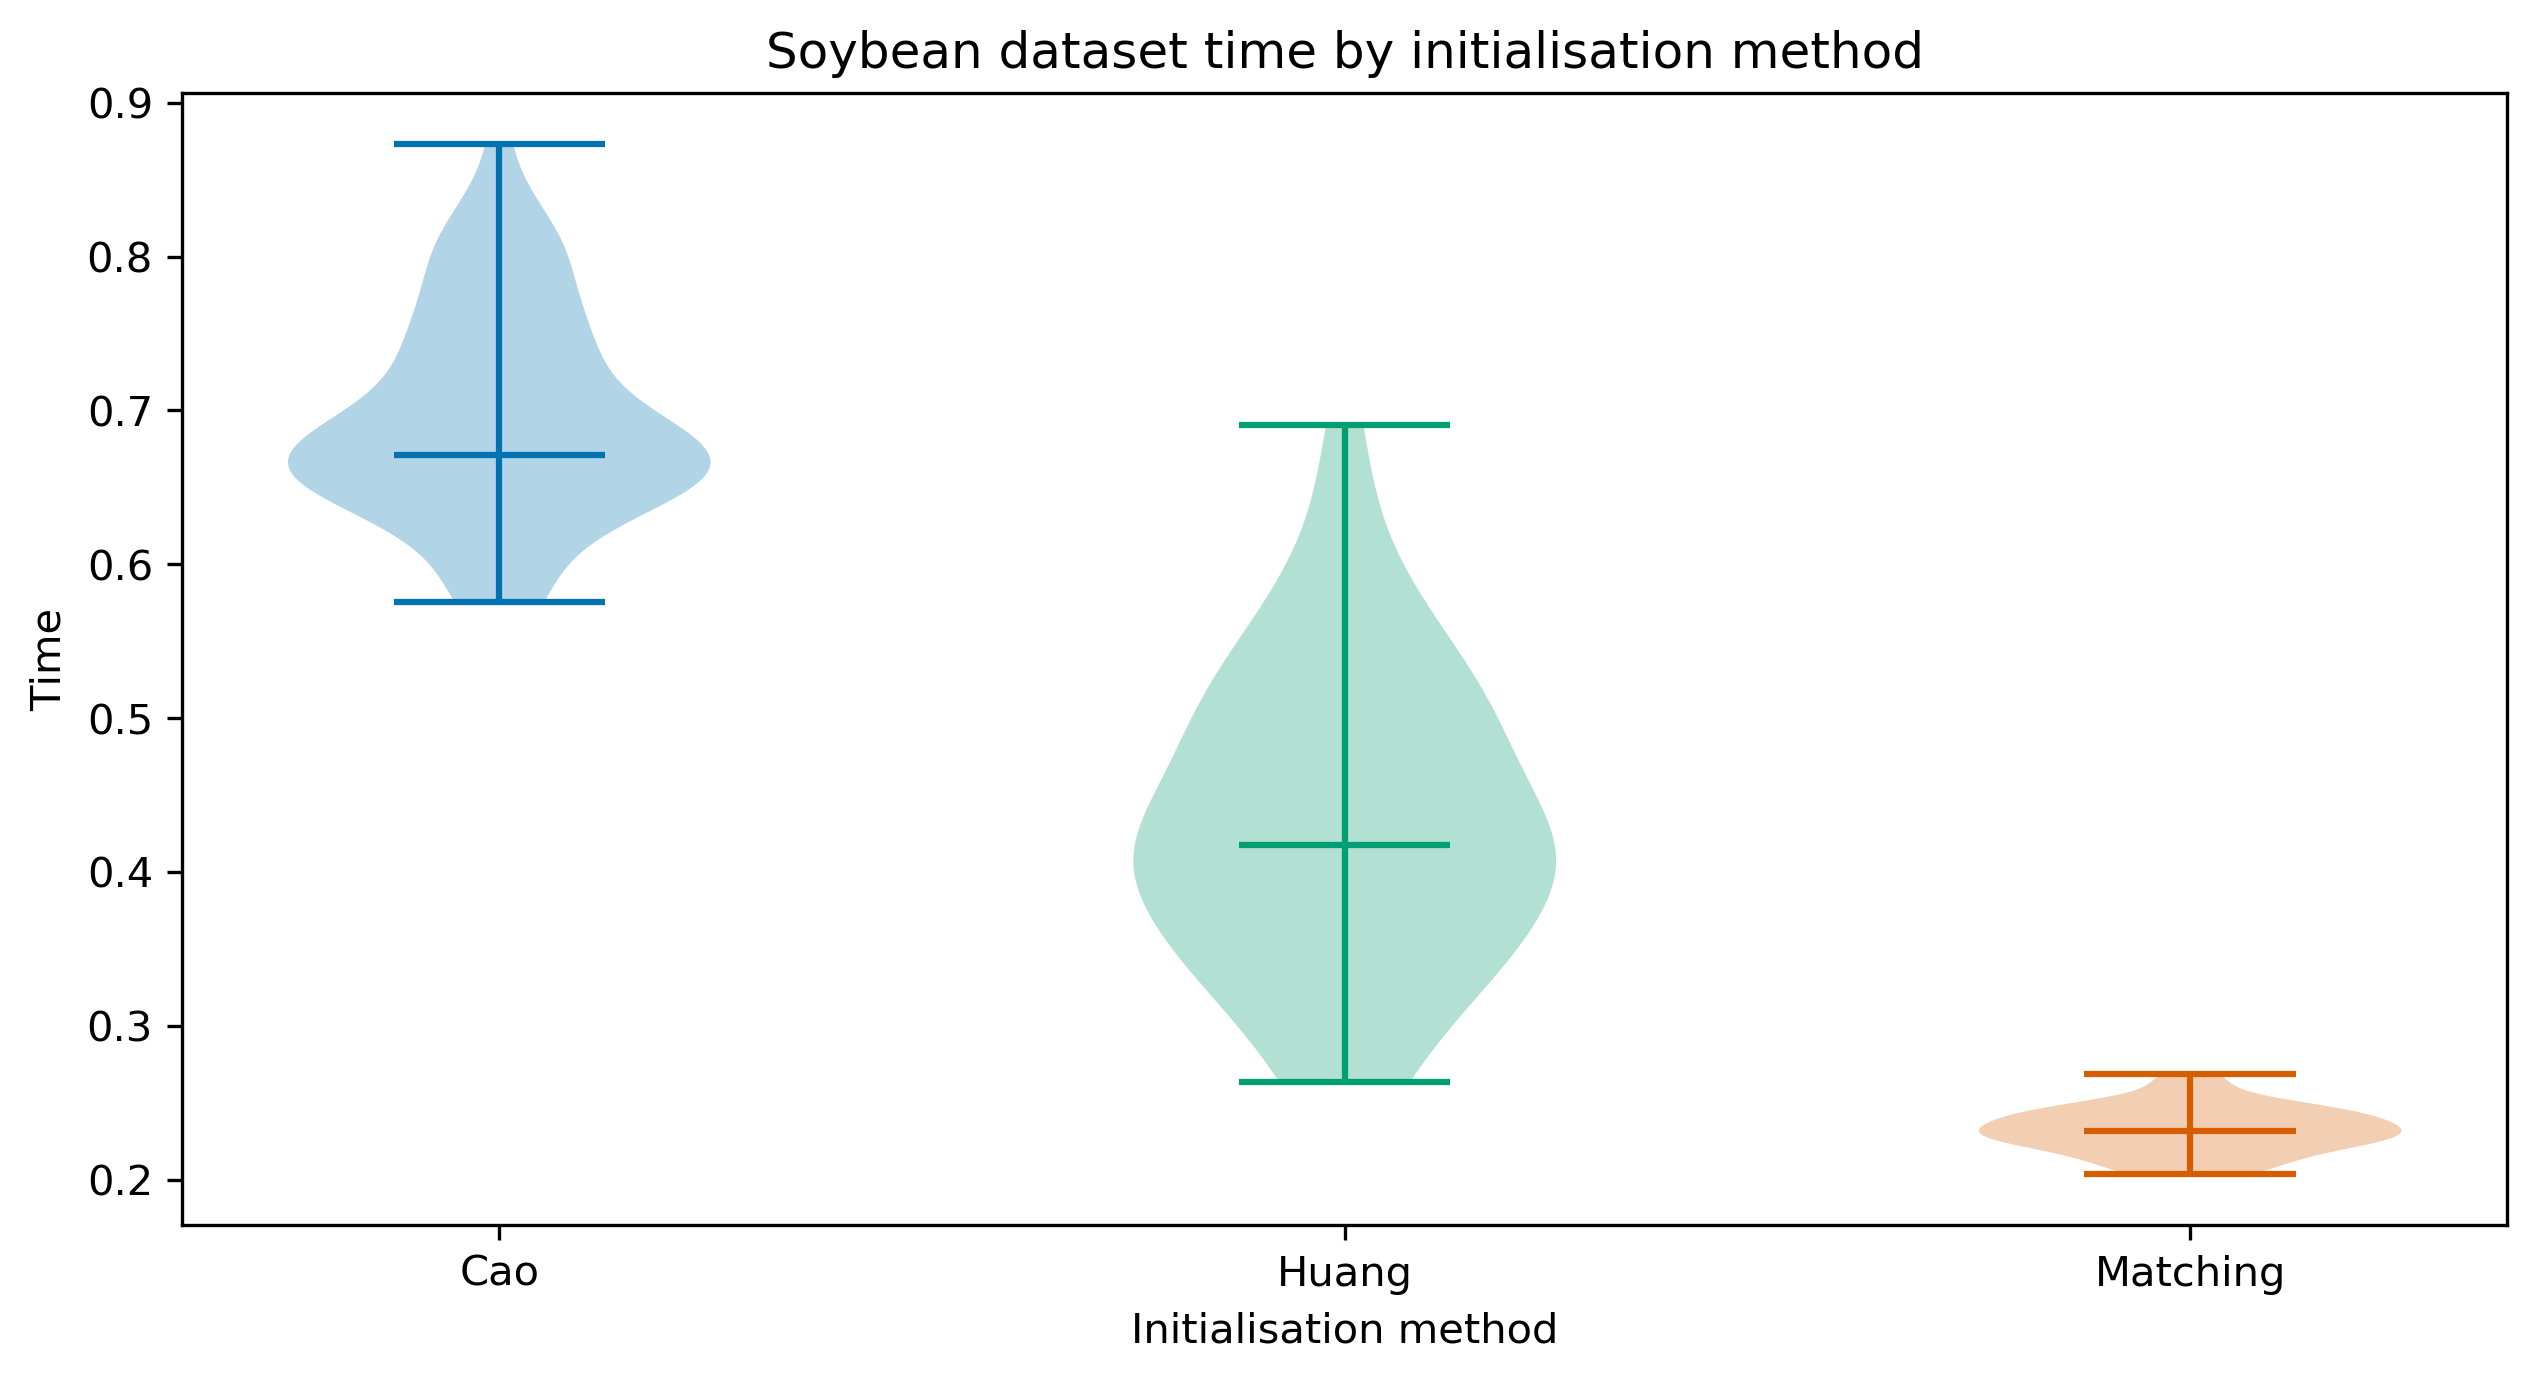

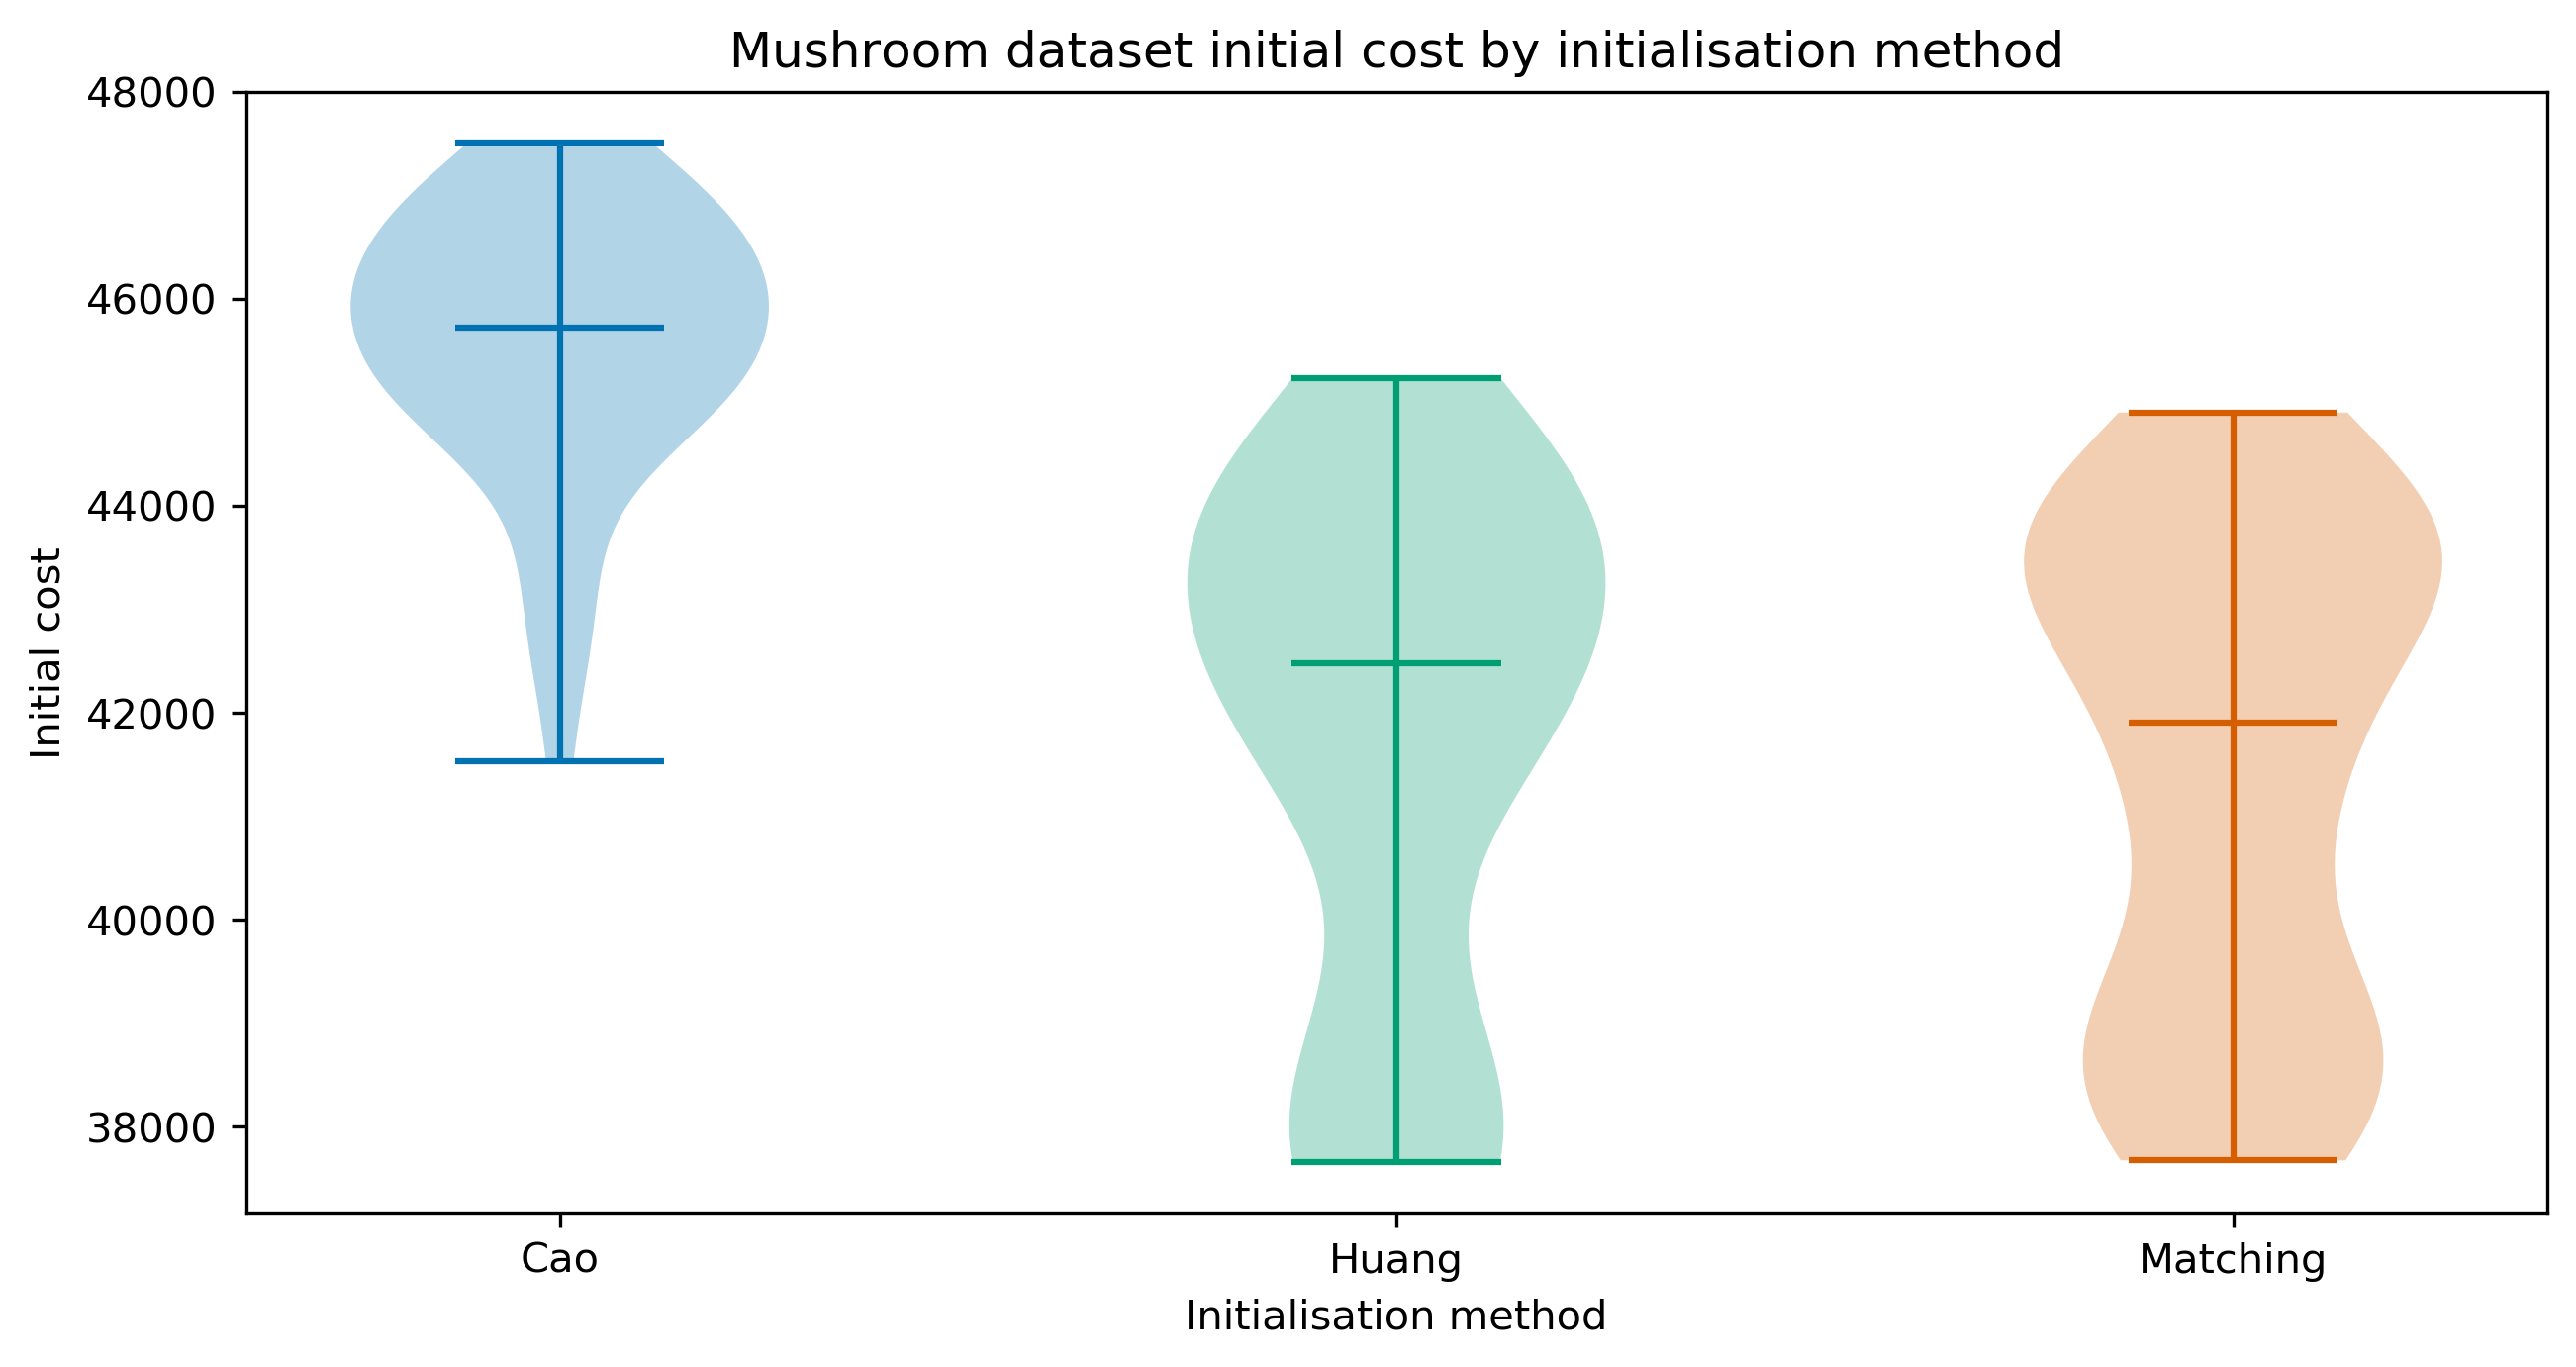

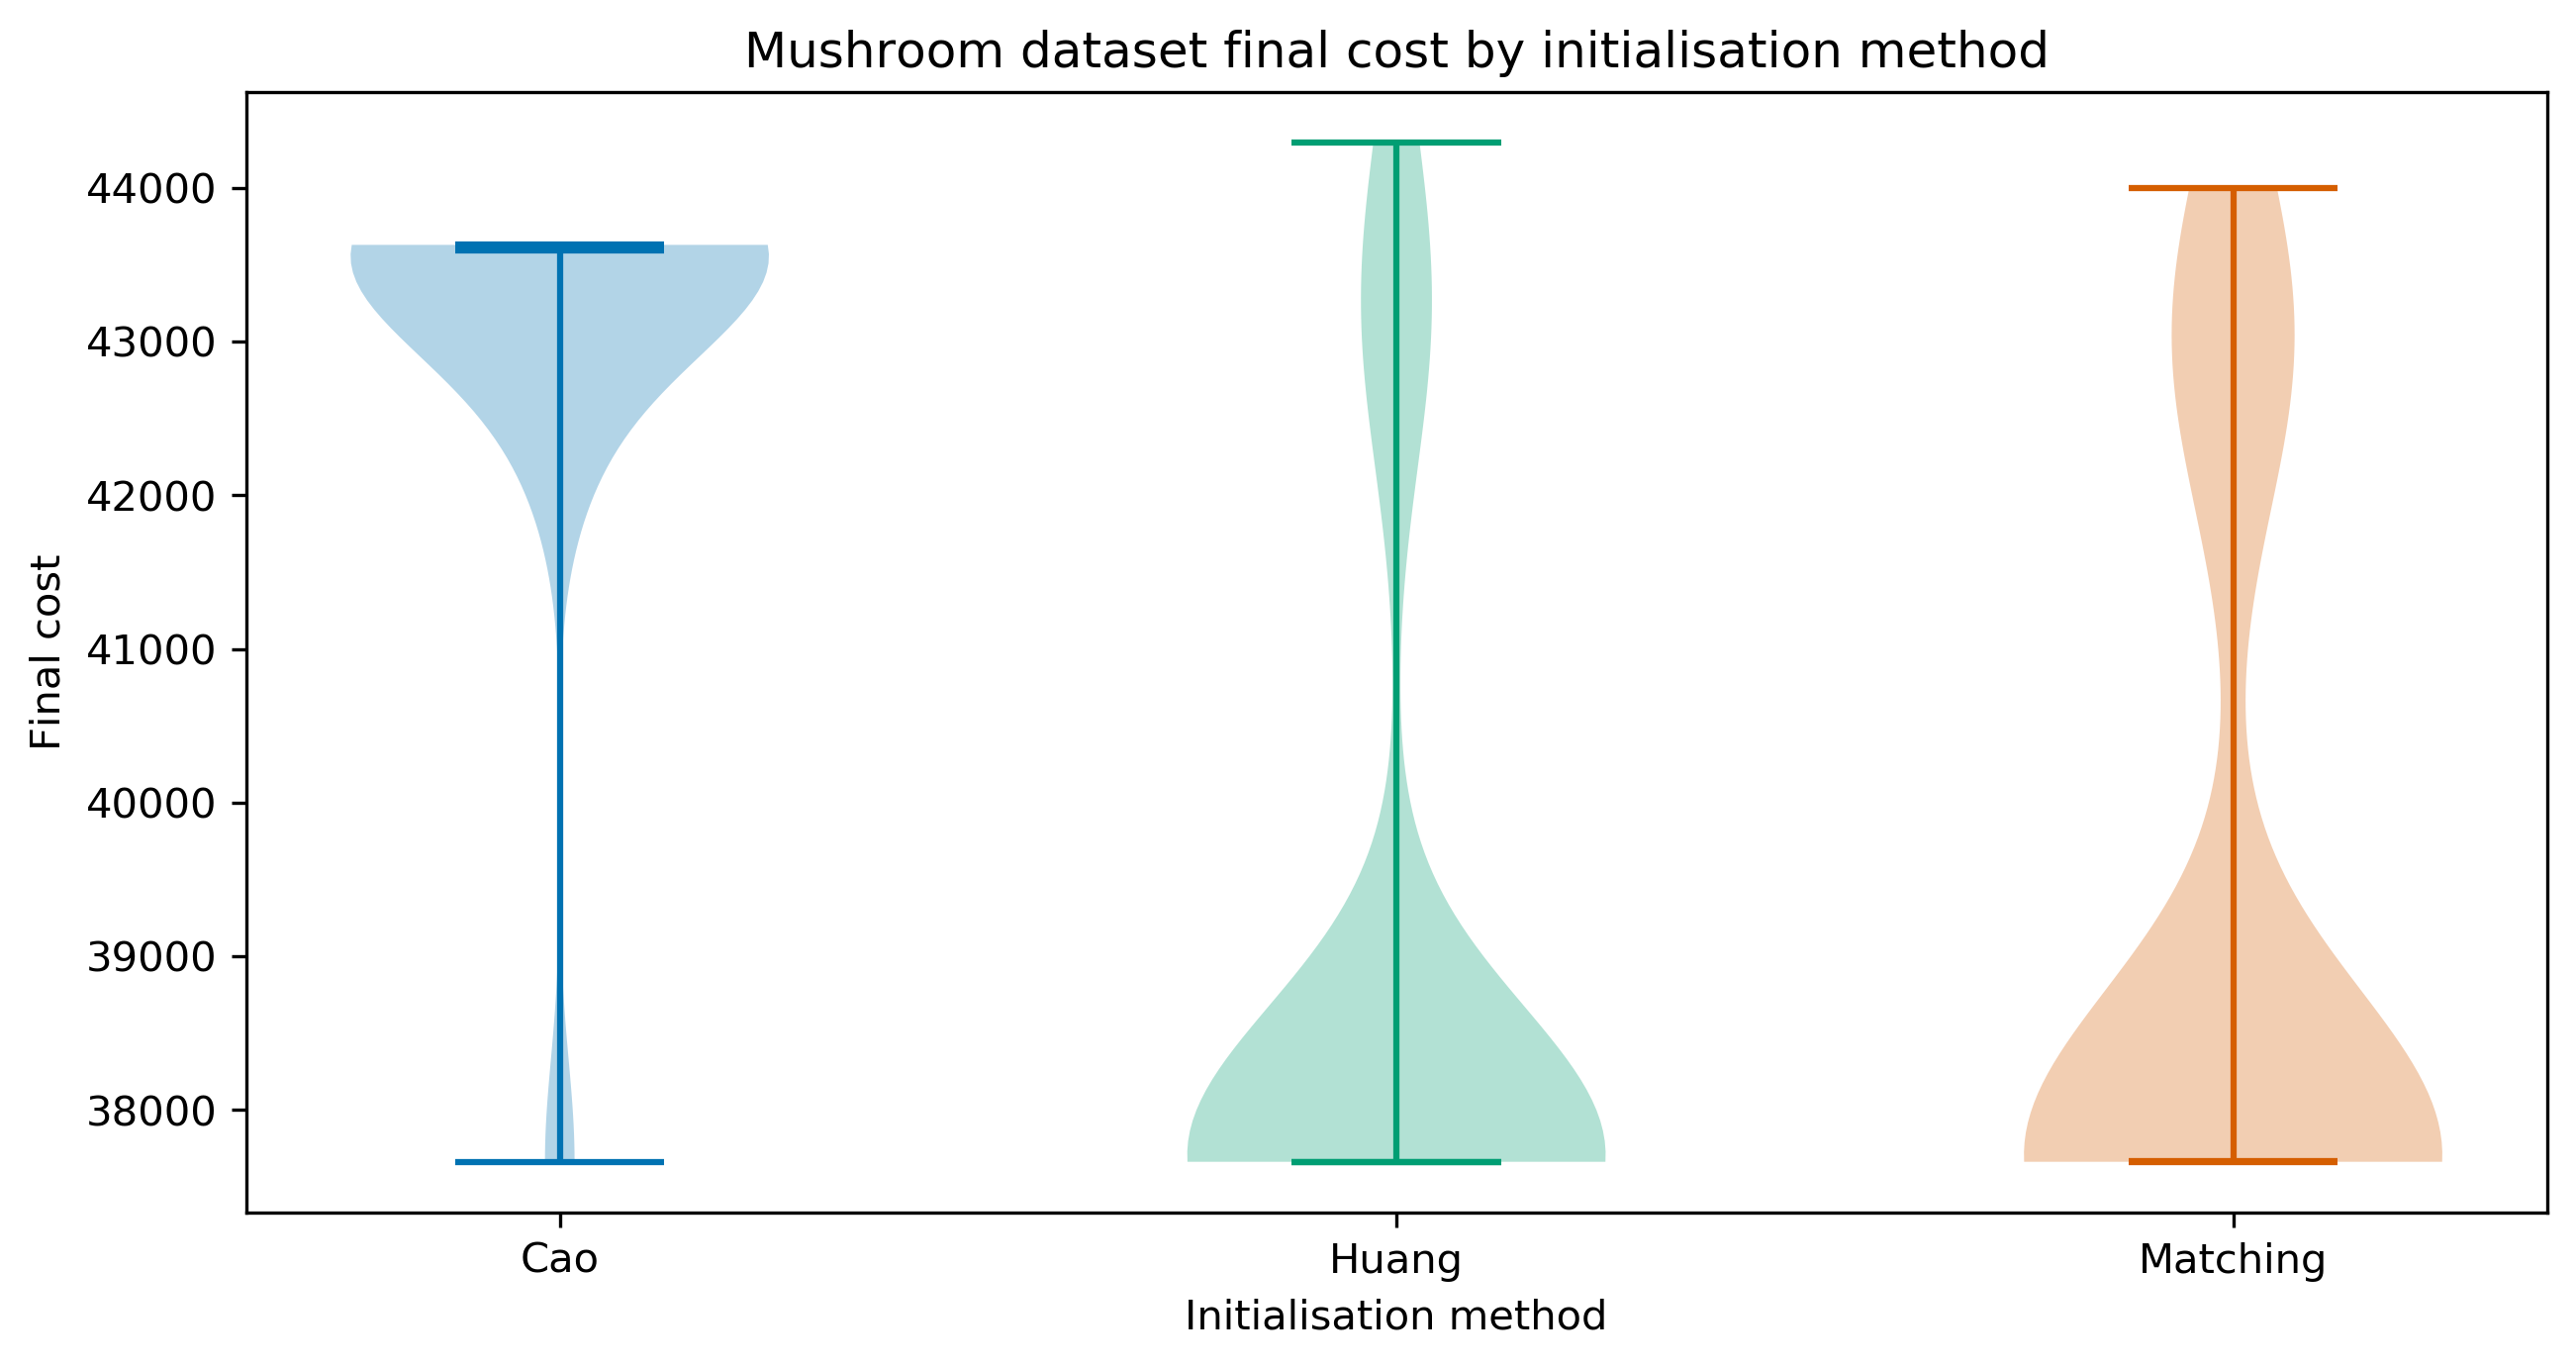

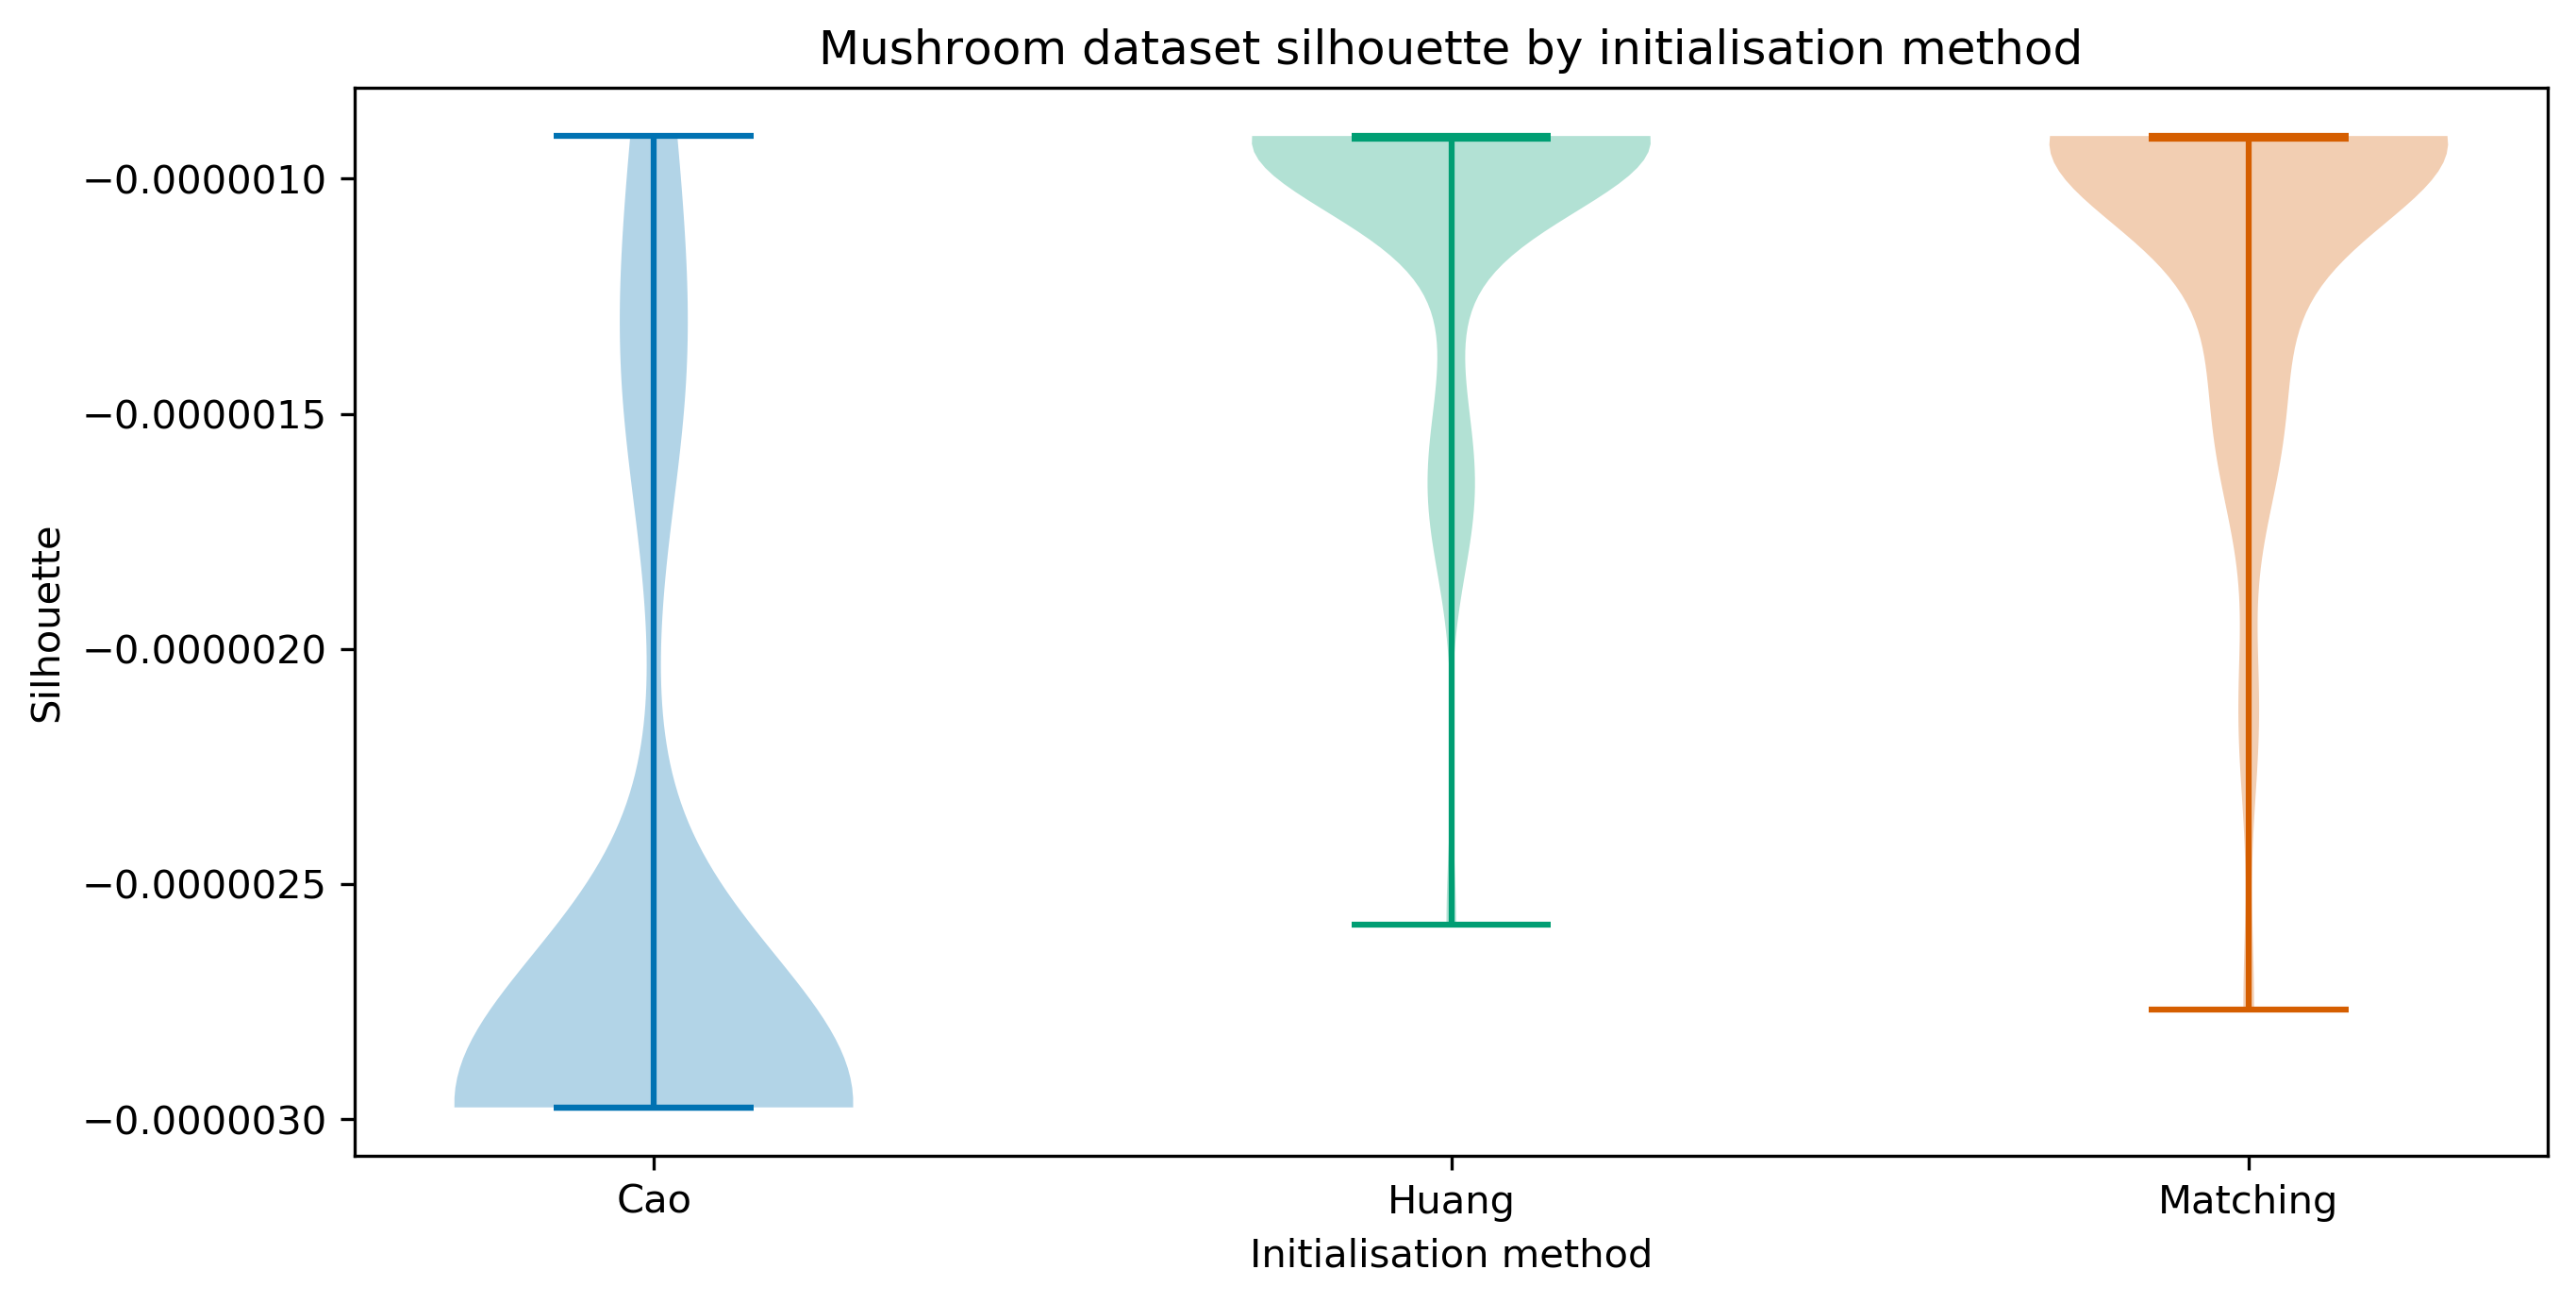

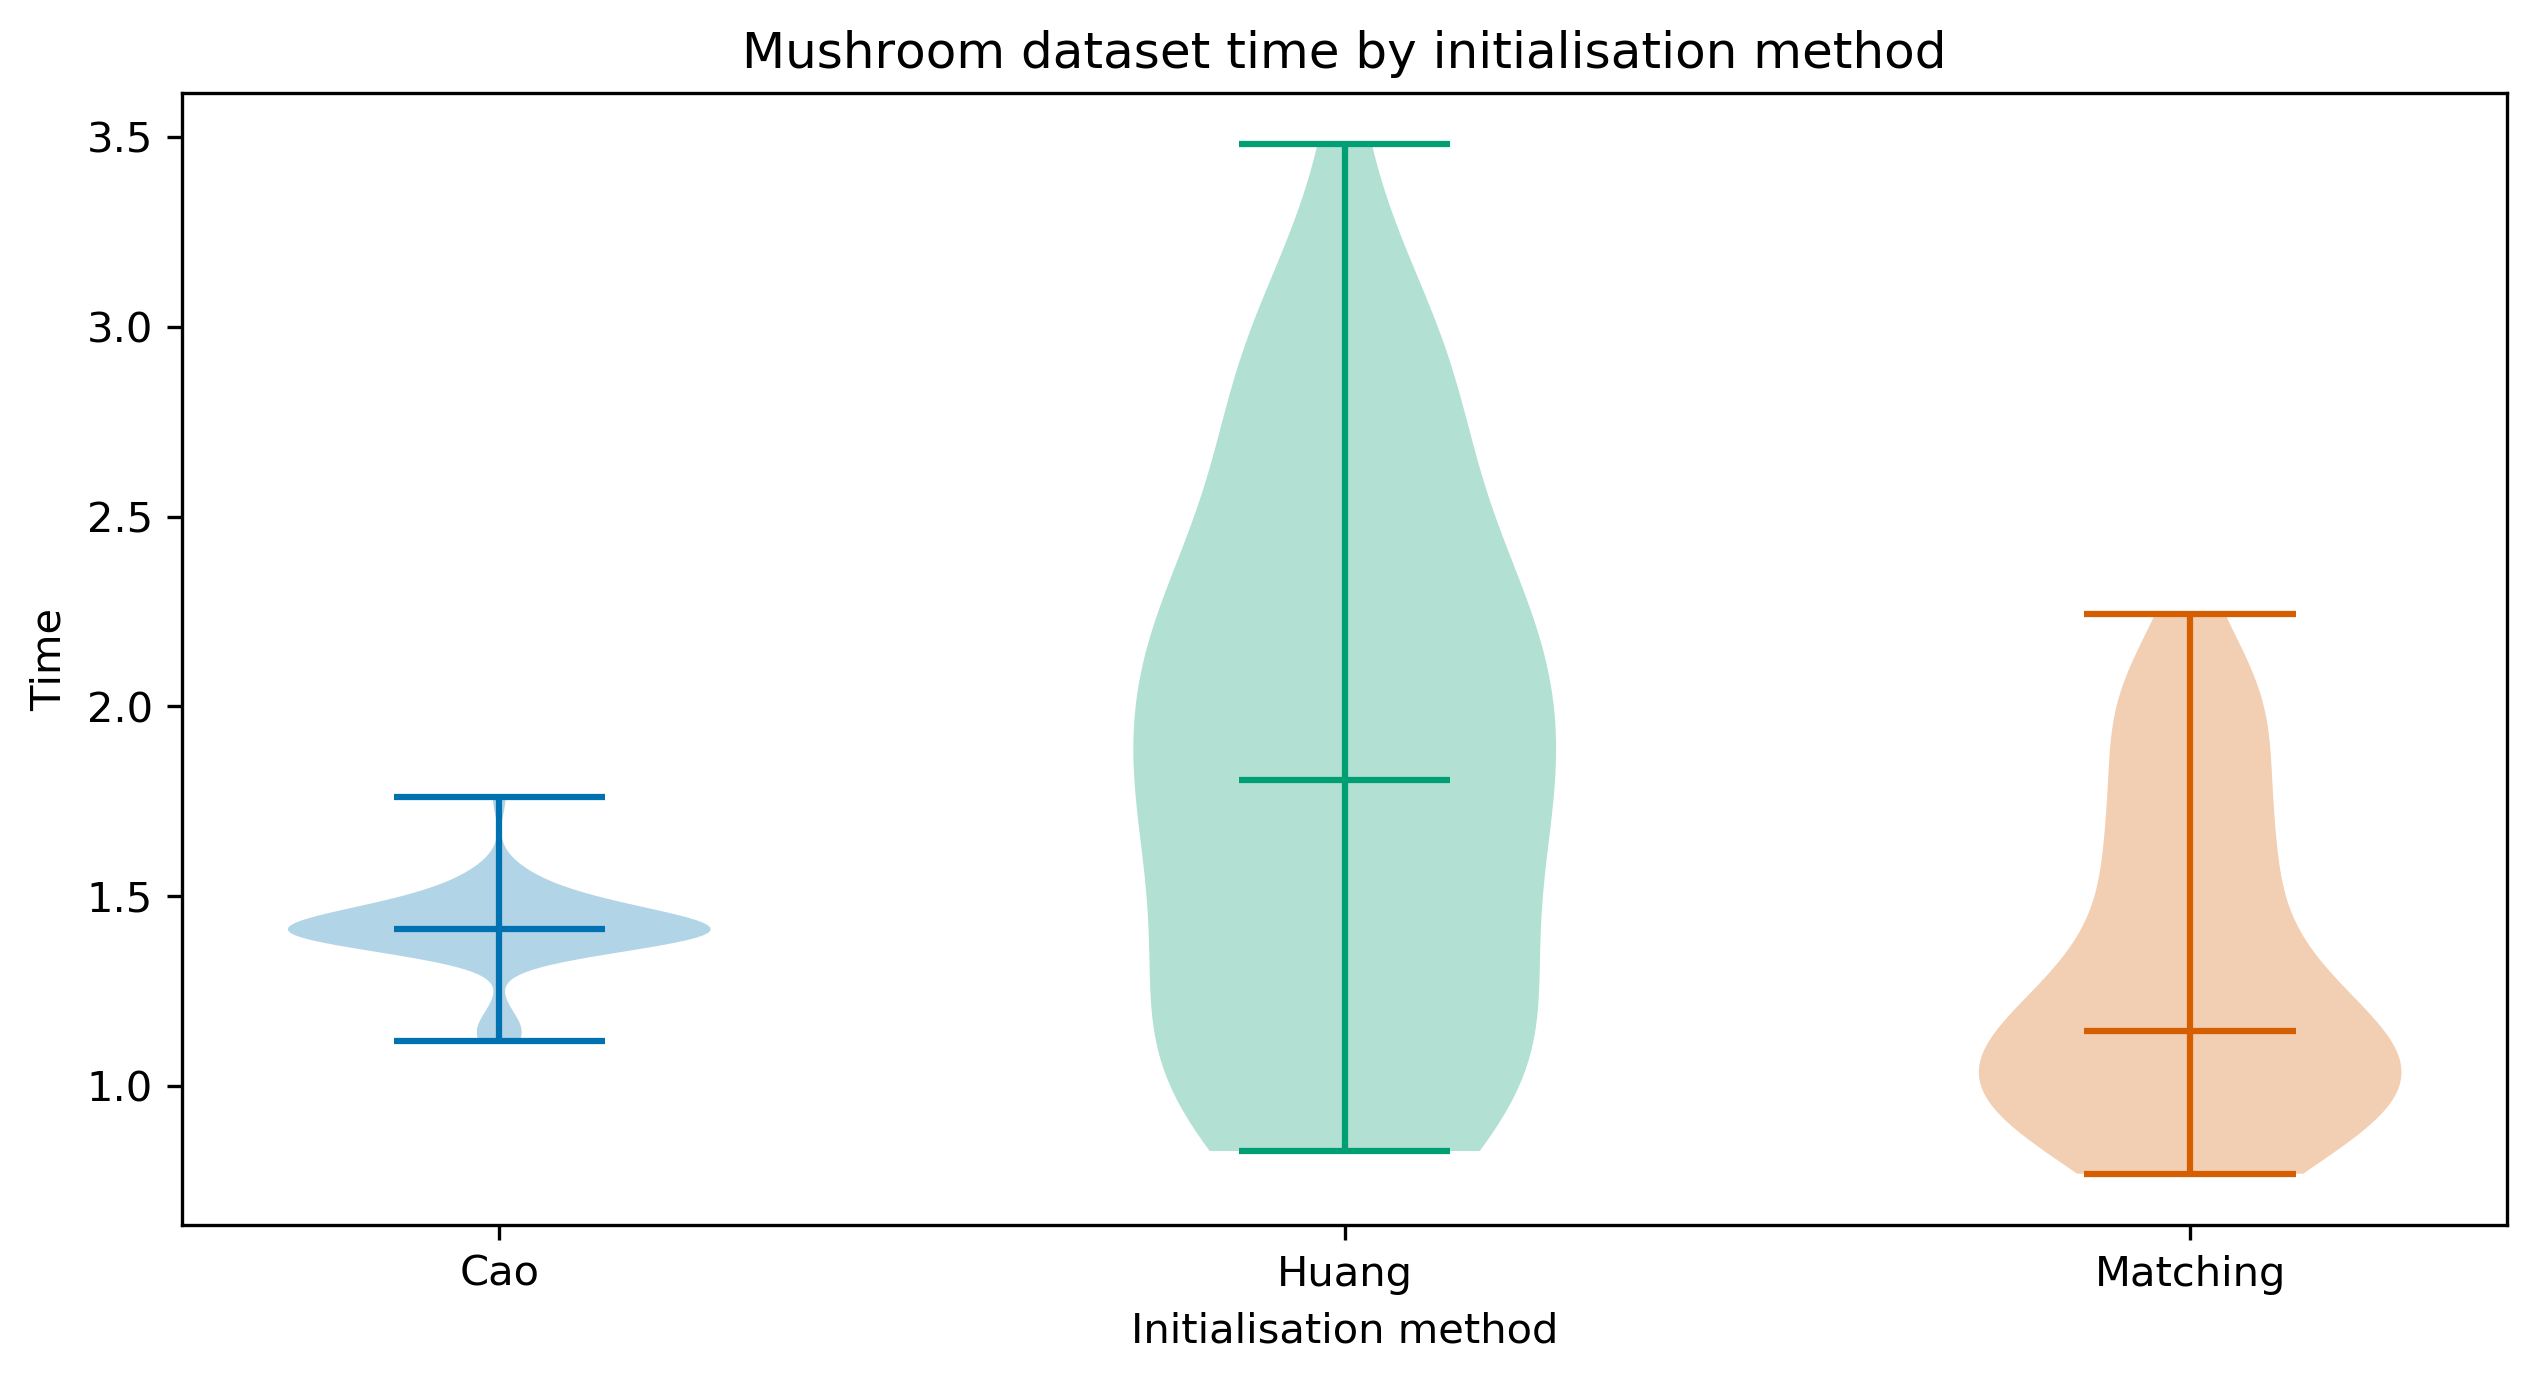

In [54]:
# for name in ("zoo", "breast_cancer", "soybean", "mushroom"):
#     for column in ("initial_cost", "final_cost", "silhouette", "time"):
#         violin_plots(name, column, destination="../img/")

# Get result tables


In [55]:
def get_summary(name, root=None, destination=None):

    results = pd.read_csv(f"{root}{name}_results.csv")

    means = results.groupby("initialisation")[
        ["initial_cost", "final_cost", "silhouette", "n_iterations", "time"]
    ].mean()

    stds = results.groupby("initialisation")[
        ["initial_cost", "final_cost", "silhouette", "n_iterations", "time"]
    ].std()

    summary = pd.DataFrame(columns=means.columns, index=means.index)
    for j, column in enumerate(means):
        for i, _ in enumerate(means[column]):
            summary.iloc[i, j] = (
                f"{means.iloc[i, j]:.2f} ({stds.iloc[i, j]:.3f})"
            )

    summary.columns = ["Initial cost", "Final cost", "Silhouette", "No. iterations", "Time"]
    summary.index = ["Cao", "Huang", "Matching"]

    if destination is not None:
        summary.to_latex(f"{destination}{name}_summary.tex")

    return summary

In [56]:
# for name in ("zoo", "breast_cancer", "soybean", "mushroom"):
#     get_summary(name, "../data/", "../tex/")